In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json
from copy import deepcopy

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
style.use('default')

import Pyro4.util

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241007')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241007


In [6]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Set the qubits/resonators to probe

## [Auto0] SET 2Q QUBIT SWAP PARAMETERS

In [8]:
# qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
# init_state = '|0>|1>'
# setup_ZZ = None
# # measure_qubits = [qubits[0], qubits[1], 3]
# measure_qubits = qubits
# qDrive = qubits[0] # normal new protocol

qubits = [3, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|1>|1>' # for everything else
setup_ZZ = 0 # for the amp rabi chevron
# measure_qubits = [qubits[0], qubits[1], 2]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

# init_state = '|0>|2>'
# qDrive = qubits[1]


# f0-g1
# # init_state = '|0>|0>'
# # qDrive = 1 # resonator f0-g1

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [10]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [11]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

# ZZ shifted pi pulses

## Pulse probe coupling spectroscopy

Sweep qubit A frequency after applying pi pulse to qubit B.

In [101]:
qubits = [1, 2] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

In [ ]:
qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_coupling_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1
npts = 100

qZZspec.cfg.expt = dict(
    start=qZZspec.cfg.device.qubit.f_Q1_ZZ[qubits[1]]-span/2,
    # start=qZZspec.cfg.device.qubit.f_ge[qubits[0]]-span/2,
    # start=3458.5-span/2,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    pulseB=True, # Whether to apply pi pulse to qubit B
    length=1, # qubit 0 probe constant pulse length [us]
    gain=100, # qubit 0 const pulse gain
    pulse_type='gauss',
    qubits=qubits,
)

# qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qZZspec.cfg)

qZZspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# qZZspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_coupling_spectroscopy_qubit01.h5')
# data = qZZspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qZZspec.display(data=data, fit=True)

qZZspec.analyze(fit=True, signs=[1, -1, 1])
qZZspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qZZspec.save_data()

## Length rabi for Q1 with QA in e

In [ ]:
lengthrabiZZ = meas.LengthRabiPiZZExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_ZZ_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiZZ.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubits=qubits,
)
# lengthrabiZZ.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabiZZ.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabiZZ.analyze(data=temp_data, fit=True)

lengthrabiZZ.analyze(fit=True)
lengthrabiZZ.display(fit=True)

In [ ]:
lengthrabiZZ.save_data()

# 2Q swap frequencies

Estimate 2Q swap frequencies analytically

In [ ]:
f_ge = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_ef = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)

print('f_EgGf: need indices 0, 2, 3')
print(f_ge[1] + f_ef[1] - f_ge)
print('f_EgGf_Q: indices 2, 3')
print(f_ge[2] + f_ef[2] - f_ge[1])
print(f_ge[3] + f_ef[3] - f_Q1_ZZ[0])
print('f_EgGf for Q3 if switch is in g')
print(f_ge[3] + f_ef[3] - f_ge[1])
print('f_EgGf for Q2 if switch is in 3')
print(f_ge[2] + f_ef[2] - f_Q1_ZZ[0])

## Pulse probe eg-gf spectroscopy

In [ ]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 40
npts = 150

qEgGfspec.cfg.expt = dict(
    # start=qEgGfspec.cfg.device.qubit.f_ge[1] - span/2, # Eg-Gf probe frequency [MHz]
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=1900,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=2, # Eg-Gf probe constant pulse length [us]
    gain=3000, # Eg-Gf const pulse gain
    qubits=qubits,
)
# qEgGfspec.cfg.device.readout.relax_delay = [50]*4
# qEgGfspec.cfg.device.readout.relax_delay = [100, 100, 100, 100]
# qEgGfspec.cfg.device.readout.length = [5, 5, 5, 5]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
sign = [[1, -1], [-1, 1]] # [iA, qA], [iB, qB]
qEgGfspec.analyze(fit=True, sign=sign)
qEgGfspec.display(fit=True, sign=sign)

In [ ]:
qEgGfspec.save_data()

### Pulse probe EgGF power sweep

In [ ]:
sweepspecEgGf = meas.PulseProbeEgGfSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_len_sweep_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 75
npts_f = 150
# npts_f = 10

span_len = 20
npts_len = 10
# npts_len = 3

sweepspecEgGf.cfg.expt = dict(
    start_f=sweepspecEgGf.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # Eg-Gf probe frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_len=1,
    step_len=int(span_len/npts_len), # len step size
    expts_len=npts_len, # Number experiments stepping len from start
    reps=500,
    rounds=40, # Number averages per point
    gain=30000, # ef const pulse length [us]
    qubits=qubits,
)
sweepspecEgGf.cfg.device.readout.relax_delay = [100, 100, 100, 100]
sweepspecEgGf.cfg.device.readout.length = [5, 5, 5, 5]
sweepspecEgGf.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

sweepspecEgGf.analyze()
sweepspecEgGf.display()

In [ ]:
3452+3318-4763

## [Auto1] Rabi eg-gf chevron (freq vs. amplitude)

In [98]:
rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqgain_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_gain = 25000
# span_gain = 7000
# npts_gain = 10
# span_gain = 0
npts_gain = 25

span_f = 10 # MHz
npts_f = 5
# span_f = 0
npts_f = 25

rabiEgGfFreqGainChevron.cfg.expt = dict(
    start_gain=5000, # qubit gain [dac level]
    # start_gain=18000, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    # start_f=2012 - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - 5 - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    reps=30,
    rounds=10,
    # pi_EgGf_sigma=0.4368, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='flat_top',
    # pulse_type='const',
    setup_ZZ=setup_ZZ,
    # setup_ZZ=None,
    qDrive=qDrive,
    # qDrive=1,
    qubits=qubits,
    measure_qubits=measure_qubits,
)

# rabiEgGfFreqGainChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqGainChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqGainChevron.cfg)

rabiEgGfFreqGainChevron.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-392.35, 5794.5, 500, -230.5], 'gain': [0.5, 0.12, 0.5, 0.2], 'readout_length': [5, 5, 5, 5], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.497481224433, 4572.845483074933, 0.0, 4209.877269497305, 4207.2388111170285, 0.0, 4208.25432515729], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.908045977012, 5146.7827380952385], 'f_f0g1': [1184.4, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653

  0%|          | 0/25 [00:00<?, ?it/s]

QA: max at gain 14000 freq 5151.382738095239
QB: min at gain 22000 freq 5146.982738095238


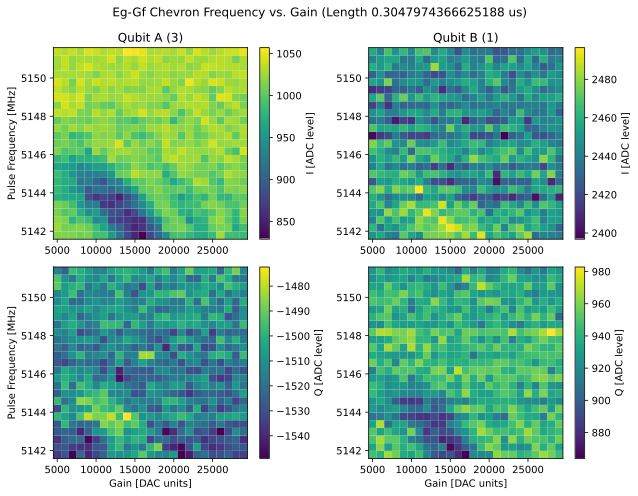

In [99]:
# # TESTING
# rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_rabi_EgGf_gainlen_chevron_qubit01.h5')
# rabiEgGfFreqGainChevron.cfg.expt = attrs['config']['expt']
# print(temp_data.keys())
# rabiEgGfFreqGainChevron.display(data=temp_data, saveplot=True) #, plot_freq=2024.5, plot_gain=2125)
# data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=data, fit=True)

rabiEgGfFreqGainChevron.analyze(data=None)
rabiEgGfFreqGainChevron.display(fit=False, data=None) #, plot_freq=5883.9, plot_gain=21000)

In [ ]:
rabiEgGfFreqGainChevron.save_data()

## Rabi eg-gf chevron (freq vs. len)

1. Once picked a good gain/len/freq, make sure the freq is really dialed in by doing a cut through the length.
2. Calibrate simultaneous pulses by doing the same thing while playing the other pulse

In [ ]:
rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# span_f = 10 # MHz
span_f = 1.5 # MHz
npts_f = 100
# npts_f = 25

# start_len = 0.0
# span_len = 1.5*rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# npts_len = 15
start_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
span_len = 0
npts_len = 1

print(measure_qubits)
print(qubits)
  
rabiEgGfFreqLenChevron.cfg.expt = dict(
    # start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2 - 20, # start freq [MHz],
    start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - 0.5*span_f, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f+1, # number of different freq experiments, 
    start_len=start_len, # pulse length (sigma) [us]
    step_len=span_len/npts_len, # [us]
    expts_len=npts_len,
    # gain=30000,
    # reps=800,
    reps=2000,
    loops=1,
    pulse_type='flat_top',
    post_process=None, #'threshold',
    # singleshot_reps=10000,
    # sigma_ramp_cycles=10,
    measure_f=None,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    # qubits_simulswap=[2, 1],
    # qDrive_simul=2,
)

# rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqLenChevron.cfg)

try:
    rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
data = rabiEgGfFreqLenChevron.analyze(data=None, fit=False)
rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, -1, -1, 1])

rabiEgGfFreqLenChevron.data = data

# print('Saved', rabiEgGfFreqLenChevron.save_data())

plt.figure(figsize=(9, 8))
if qubits[0] == 3: sign = 1
elif qubits[0] == 2: sign = -1
good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
# bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
# for i in range(len(data['lenpts'])):
#     plt.plot(data['freqpts'], data['avgi'][0][:, i])

amps_freq_cut_qA = data['amps'][0][:, len_ind]
amps_freq_cut_qB = data['amps'][1][:, len_ind]
p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
print('QA freq with max amp', freq_max_amp_qA)
print('QB freq with min amp', freq_min_amp_qB)
plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
plt.subplot(211, title=f'QA ({qubits[0]})')
plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
plt.ylabel('Amplitude [ADC units]')

plt.subplot(212, title=f'QB ({qubits[1]})')
plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
# plt.axvline(5890.45, color='r', linestyle='--')
# plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(data['freqpts'], amps_freq_cut_qA+amps_freq_cut_qB, '.-', label='qA+qB', color=default_colors[0])


In [ ]:
filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00123_rabi_EgGf_freqlen_chevron_qubit21.h5'
# filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00025_rabi_EgGf_freqlen_chevron_qubit31.h5'

rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=None,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)
temp_data, attrs = prev_data(filename, None)
data = temp_data
data = deepcopy(data)

# # print(temp_data['amps'].shape)
# # print(data['amps'].shape)
# for fit_axis in ['amps', 'avgi', 'avgq']:
#     data[fit_axis] = np.concatenate((temp_data[fit_axis], data[fit_axis]), axis=1)
# data['freqpts'] = np.concatenate((temp_data['freqpts'], data['freqpts']), axis=None)

# print(data['freqpts'])
# rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, 1, -1, 1])

rabiEgGfFreqLenChevron.data = data
rabiEgGfFreqLenChevron.cfg = AttrDict(attrs['config'])
qubits = rabiEgGfFreqLenChevron.cfg.expt.qubits
if qubits[0] == 3: sign = 1
elif qubits[0] == 2: sign = -1
good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

plt.style.use('dark_background')

rows = 2
cols = 1
index = rows*100 + cols*10
fig, axs = plt.subplots(rows, cols, figsize=(9*cols, 7), gridspec_kw={'height_ratios': [1, 1]}, sharex='col')
ax1, ax2 = axs
plt.suptitle("$|eg\\rangle-|gf\\rangle$"+ f" Frequency vs. Length (Q{qubits[0]}/Q{qubits[1]})")

plt.sca(ax1)
data['amps'][0] = (data['amps'][0] - min(data['amps'][0])) / (max(data['amps'][0]) - min(data['amps'][0]))
rabiEgGfFreqLenChevron.plot_rabi_chevron(data, 'amps', plot_xpts=1000*data['lenpts'], plot_ypts=data['freqpts'], plot_rabi=False, q_index=0, show_cbar=False)
# plt.axhline(bad_ZZ_freq, color='r', linestyle='--')
# print(((data['freqpts'][-1] - data['freqpts'][0])//4))
# yticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
yticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
plt.yticks(ticks=yticks, fontsize=24)
plt.ylabel('Frequency\n(MHz)', fontsize=24)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(f'Population (Scaled)', size='large')
# cbar.ax.set_title(f'Q{qubits[0]}')

plt.sca(ax2)
# data['amps'][1] = (data['amps'][1] - min(data['amps'][1])) / (max(data['amps'][1]) - min(data['amps'][1]))
data['amps'][1] = (data['amps'][1] - max(data['amps'][1])) / (min(data['amps'][1]) - max(data['amps'][1]))
rabiEgGfFreqLenChevron.plot_rabi_chevron(data, 'amps', plot_xpts=1000*data['lenpts'], plot_ypts=data['freqpts'], plot_rabi=False, q_index=1, show_cbar=False)
# plt.axhline(bad_ZZ_freq, color='r', linestyle='--')
# yticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
yticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
plt.ylabel('Frequency\n(MHz)', fontsize=24)
plt.xlabel('Length (ns)', fontsize=24)
plt.yticks(ticks=yticks, fontsize=24)
plt.xticks(fontsize=24)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(f'Population (Scaled)', size='large')
# cbar.ax.set_title(f'Q{qubits[1]}')

plt.subplots_adjust(hspace=0.07)
# plt.tight_layout()

plot_filename = filename[:-3]+'.svg'
plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
print('Saved', plot_filename)

plt.show()




# # filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00122_rabi_EgGf_freqlen_chevron_qubit21.h5'
# # temp_data, attrs = prev_data(filename, None)
# # data = temp_data
# # data = deepcopy(data)

# # # print(temp_data['amps'].shape)
# # # print(data['amps'].shape)
# # for fit_axis in ['amps', 'avgi', 'avgq']:
# #     data[fit_axis] = np.concatenate((temp_data[fit_axis], data[fit_axis]), axis=1)
# # data['freqpts'] = np.concatenate((temp_data['freqpts'], data['freqpts']), axis=None)

# # print(data['freqpts'])
# # rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, 1, -1, 1])

# rabiEgGfFreqLenChevron.data = data
# rabiEgGfFreqLenChevron.cfg = AttrDict(attrs['config'])
# qubits = rabiEgGfFreqLenChevron.cfg.expt.qubits
# if qubits[0] == 3: sign = 1
# elif qubits[0] == 2: sign = -1
# good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
# bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

# plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# len_ind = np.argmin(np.abs(data['lenpts']-plot_len))


# fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 7), gridspec_kw={'height_ratios': [1, 1]}, sharex='col')
# ax1, ax2 = axs
# plt.suptitle(f"Q{qubits[0]} Cut Through Length {data['lenpts'][len_ind]:.3} ns")

# plt.sca(ax1)
# data['amps'][0] = (data['amps'][0] - min(data['amps'][0])) / (max(data['amps'][0]) - min(data['amps'][0]))
# plt.plot(data['freqpts'], data['amps'][0][:, len_ind], '.-')
# # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
# plt.ylabel('Population\n(Scaled)', fontsize=24)
# plt.yticks(ticks=[0, 0.5, 1.0], fontsize=24)

# plt.sca(ax2)
# data['amps'][1] = (data['amps'][1] - min(data['amps'][1])) / (max(data['amps'][1]) - min(data['amps'][1]))
# plt.plot(data['freqpts'], data['amps'][1][:, len_ind], '.-')
# # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
# plt.ylabel('Population\n(Scaled)', fontsize=24)
# plt.xlabel('Frequency (MHz)', fontsize=24)
# plt.yticks(ticks=[0, 0.5, 1.0], fontsize=24)
# # xticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
# xticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
# plt.xticks(ticks=xticks, fontsize=24)

# plt.subplots_adjust(hspace=0.07)

# plot_filename = filename[:-3]+f'_cut.svg'
# plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
# print('Saved', plot_filename)

# plt.show()

## Length Rabi eg-gf single sweep

In [ ]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# start_len = lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0
# npts_len = 10

start_len = 0
# span_len = 3.75*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
span_len = 2*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 15
# start_len = 0.999*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0.001*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
npts_len = 50


lengthrabiEgGf.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    # step=0,
    # expts=1,
    step=span_len/npts_len, # [us]
    expts=npts_len+1,
    # reps=15000,
    # reps_f=25000,
    reps=10000,
    reps_f=1000,
    loops=1,
    pulse_type='flat_top',
    post_process=None,
    # post_process=None,
  
    # singleshot_reps=40000,
    # singleshot_reps=1000,
    measure_f=None,
    # measure_f=[qDrive],
    # init_state=init_state,
    init_state = '|1>|1>',
    # init_state = '|1>|0+1>',
    # init_state = 'Q2Q1_|2>|0>',
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    test_pi_half=False,
    readout_cool=False,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
try:
    lengthrabiEgGf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
lengthrabiEgGf.save_data()

In [ ]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=True, post_select_calib=False, post_select_experiment=False, separate_correction=False, ps_qubits=[0, 1, 2], verbose=False)

# plt.figure()
# print(lengthrabiEgGf.cfg.expt.measure_qubits)
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][0], label='q1')
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][1], label='q2')
# plt.ylabel('rotated amplitude')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 01, 10, 11
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q2 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0), label='q2 g counts')
# plt.ylabel('counts measurement 0')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 02, 10, 12
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q2 f counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0), label='q2 g counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0), label='gf counts')
# plt.ylabel('counts measurement 1')
# plt.legend()
# plt.show()

lengthrabiEgGf.display(fit=True)

# print(lengthrabiEgGf.data['counts_calib'])

### Length rabi with post selection

In [117]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# start_len = lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0
# npts_len = 10

start_len = 0
# span_len = 3.75*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
span_len = 1.0*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 15
# start_len = 0.999*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 2*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 50
npts_len = 1

lengthrabiEgGf.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    # step=0,
    # expts=1,
    step=span_len/npts_len, # [us]
    expts=npts_len+1,
    reps=20000,
    # reps_f=20000,
    # reps=100,
    reps_f=200,
    loops=1,
    pulse_type='flat_top',
    post_process='threshold',
    # post_process=None,
  
    # singleshot_reps=10000,
    singleshot_reps=20000,
    # singleshot_reps=100,
    measure_f=None,
    # measure_f=[qDrive],
    init_state=init_state,
    # init_state = '|1+0>|1>',
    # init_state = '|1>|0+1>',
    # init_state = 'Q2Q1_|2>|0>',
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,
    
    # setup_measure='qDrive_ef',

    test_pi_half=False,
    # cool_qubits=[0, 1],
    # cool_idle=[5, 5],
    
    readout_cool=True,
    n_init_readout=1,
    n_trig=1,
    init_read_wait_us=10,
    # init_read_wait_us=2,
    # use_gf_readout=True,
    
    # thresholds=[0, 403.4255711140312, 356.93670935384887, 0],
    # angles=[0, -15.164283291744868, 107.2178024864672, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [332.72639357096347, -312.0792793945312, 663.0205369628906, -231.3194316731771], [-55.472186757526444, -160.28748716436127, -169.05275673311635, -537.4039020748576], array([0., 0., 0., 0.])],
    # counts_calib=[[16091, 2293, 1360, 256], [2287, 16108, 208, 1397], [2399, 307, 14988, 2306], [414, 2510, 2206, 14870]]

)

print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
try:
    lengthrabiEgGf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.996526541673, 4572.845483074933, 0.0, 4209.877269497305, 4205.53388737822, 0.0, 4208.25432515729], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.653411964549, 5146.7827380952385], 'f_f0g1': [1184.4, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.4029640

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 83.71709292732318 	 angle (deg): 90.21923857565096 	 threshold ge: 498.69391646357184
Qubit (1) ge
ge fidelity (%): 52.34130853271331 	 angle (deg): 136.3921167974772 	 threshold ge: 450.3566853021149


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 75.91189779744494 	 angle (deg): 111.73660578813579 	 threshold ge: 240.88973756770844


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 69.61500000000001 	 angle (deg): -66.92545970997404 	 threshold ge: 52.6147522697629


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
lengthrabiEgGf.save_data()

no ps counts_raw imeasure 0 loop 0 len 0 [0.27515 0.6602  0.0166  0.04805]
no ps counts_raw imeasure 0 loop 0 len 1 [0.15155 0.10515 0.57035 0.17295]
counts calib loop 0
[[0.77155 0.16705 0.04895 0.01245]
 [0.2803  0.65635 0.01845 0.0449 ]
 [0.08295 0.0198  0.70285 0.1944 ]
 [0.0422  0.0926  0.26095 0.60425]]
keep 12648 of 20000 shots (63.24 %)
keep 12648 of 20000 shots (63.24 %)
keep 12493 of 20000 shots (62.465 %)
keep 12493 of 20000 shots (62.465 %)
keep 12556 of 20000 shots (62.78 %)
keep 12556 of 20000 shots (62.78 %)
keep 12333 of 20000 shots (61.665 %)
keep 12333 of 20000 shots (61.665 %)
counts calib loop ps 0
[[0.78462998 0.16018343 0.04514548 0.01004111]
 [0.26366765 0.68238213 0.01480829 0.03914192]
 [0.07597961 0.01728257 0.72164702 0.18509079]
 [0.03835239 0.09008352 0.25500689 0.6165572 ]]
imeasure 0 counts_calib keep 50030 of 80000 total shots (62.5375 %)
keep 12642 of 20000 shots (63.21 %)
keep 12642 of 20000 shots (63.21 %)
keep 12734 of 20000 shots (63.67 %)
keep 1273

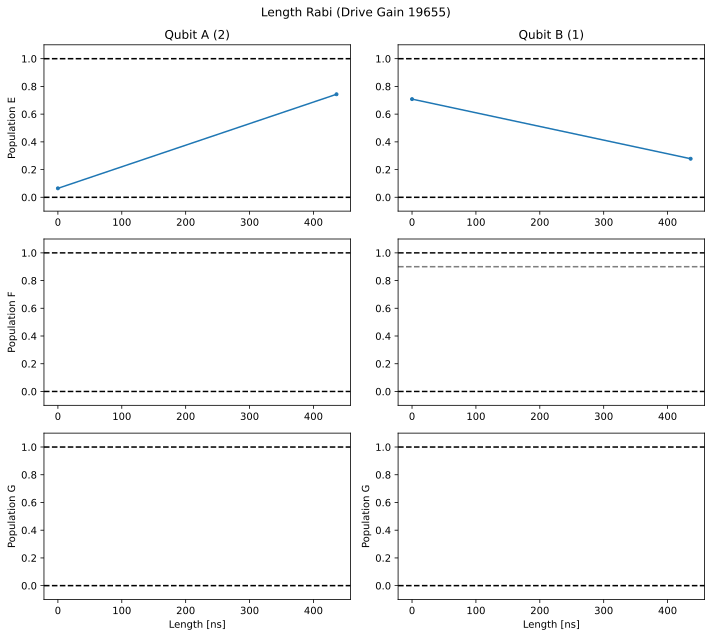

keep 63.67 %
g play_pulses [0] unrotated averages:
I 127.37305660807293 +/- 140.3374919341258 	 Q -272.16052923177085 +/- 153.73902255242152 	 Amp 300.491679121737
Rotated (theta=1.5746227617873885):
I 271.67115326919526 +/- 153.7410444682557 	 Q 128.41352616755893 +/- 140.33527690336675 	 Amp 300.4916791217369
e play_pulses [0] unrotated averages:
I 125.57741119791667 +/- 138.85749937167472 	 Q -741.4319659505207 +/- 192.29327509807436 	 Amp 751.9913871424491
Rotated (theta=1.5746227617873885):
I 740.9460254523527 +/- 192.30031595083267 	 Q 128.4135261675589 +/- 138.847748505002 	 Amp 751.9913871424492
test play_pulses [0] unrotated averages:
I 116.83341012369793 +/- 138.59244900931301 	 Q -654.956988704427 +/- 262.5553328828154 	 Amp 665.295951268233
Rotated (theta=1.5746227617873885):
I 654.505139541743 +/- 262.5744130393505 	 Q 119.33869903491816 +/- 138.55629673401927 	 Amp 665.2959512682331
g_0 play_pulses [0] unrotated averages:
I 127.23864427083332 +/- 140.94636320506157 	 Q -2

([0.8373472148607433], [498.0689089235121], 90.21923857565096)

In [119]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# lengthrabiEgGf.data = temp_data
# lengthrabiEgGf.cfg = AttrDict(attrs['config'])
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

ps_qubits = [0, 1, 2, 3]

ps_adjust = [0]*4
# ps_adjust = [-1.2, -1.0, -1.7, 0.0]
# ps_adjust_f = [-1.0, -1.0, -1.0, 0.0]
# ps_adjust_f = [-1, -1, np.inf, -1]
ps_adjust_f = [np.inf]*4

# ps_adjust = [np.inf]*4
# ps_adjust = None

apply_ps = True

lengthrabiEgGf.analyze(fit=False, post_select_calib=apply_ps, post_select_experiment=apply_ps, separate_correction=False, ps_qubits=ps_qubits, ps_adjust=ps_adjust, ps_adjust_f=ps_adjust_f)

lengthrabiEgGf.display(fit=False)

# plt.figure()
# print(lengthrabiEgGf.cfg.expt.measure_qubits)
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][0], label='q1')
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][1], label='q2')
# plt.ylabel('rotated amplitude')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 01, 10, 11
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q2 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0), label='q2 g counts')
# plt.ylabel('counts measurement 0')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 02, 10, 12
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q2 f counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0), label='q2 g counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0), label='gf counts')
# plt.ylabel('counts measurement 1')
# plt.legend()
# plt.show()


data = lengthrabiEgGf.data
histdata = dict(iqshots=[])
check_states = []
# gg, ge, eg, ee, gf, ef q1/q2(q3), g(q0), e(q0), g(q2/3), e(q2/3)
loop = 0
imeasure = 0
ilen = -1

q = 2

if q in [2, 3]:
    if lengthrabiEgGf.measure_f:
        if q == lengthrabiEgGf.cfg.expt.measure_f[0]:
            iprep_g = 0
            iprep_e = 1
            iprep_f = 4
        else:
            iprep_g = 8
            iprep_e = 9
            iprep_f = None
    else:
        iprep_g = 0
        iprep_e = 2
        iprep_f = None
elif q == 1:
    iprep_g = 0
    iprep_e = 2
    iprep_f = None
elif q == 0:
    iprep_g = 6
    iprep_e = 7
    iprep_f = None


histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, -1, :]))
check_states.append('g')
histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_e, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_e, :, -1, :]))
check_states.append('e')
if q in [2, 3] and lengthrabiEgGf.measure_f and q == lengthrabiEgGf.cfg.expt.measure_f[0]:
    histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_f, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_f, :, -1, :]))
    check_states.append('f')
histdata['iqshots'].append((data[f'ishots_raw_{imeasure}'][loop, ilen, :, -1, :], data[f'qshots_raw_{imeasure}'][loop, ilen, :, -1, :]))
check_states.append('test')

if lengthrabiEgGf.cfg.expt.readout_cool:
    histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, 0, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, 0, :]))
    check_states.append('g_0')

if imeasure == 0:
    thresholds = data['thresholds_loops'][loop]
    angles = data['angles_loops'][loop]
    ge_avgs = data['ge_avgs_loops'][loop]
    if ps_adjust is None: ps_thresholds = thresholds
    else: ps_thresholds = meas.clifford_averager_program.ps_threshold_adjust(ps_thresholds_init=thresholds, adjust=ps_adjust, ge_avgs=ge_avgs, angles=angles)
else:
    thresholds = data['thresholds_f_loops'][loop]
    angles = data['angles_f_loops'][loop]
    ge_avgs = data['gf_avgs_loops'][loop]
    if ps_adjust_f is None: ps_thresholds = thresholds
    else: ps_thresholds = meas.clifford_averager_program.ps_threshold_adjust(ps_thresholds_init=thresholds, adjust=ps_adjust_f, ge_avgs=ge_avgs, angles=angles)

_, keep_indices = meas.clifford_averager_program.post_select_shots(
    final_qubit=q,
    all_ishots_raw_q=data[f'ishots_raw_{imeasure}'][loop, ilen, :, :, :],
    all_qshots_raw_q=data[f'qshots_raw_{imeasure}'][loop, ilen, :, :, :],
    angles=angles, 
    ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
    n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
    post_process=None, verbose=False, return_keep_indices=True)

ishots_unrot = data[f'ishots_raw_{imeasure}'][loop, ilen, :, -1, :]
qshots_unrot = data[f'qshots_raw_{imeasure}'][loop, ilen, :, -1, :]
ishots_ps_unrot = ishots_unrot[:, keep_indices]
qshots_ps_unrot = qshots_unrot[:, keep_indices]
print('keep', 100*np.sum(keep_indices)/len(ishots_unrot[q]), '%')
if apply_ps:
    histdata['iqshots'].append((ishots_ps_unrot, qshots_ps_unrot))
    check_states.append('ps')

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]
if imeasure == 1 and q != 1: e_states = [2]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=histdata, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    plot=True, export=True)

# print(lengthrabiEgGf.data['counts_calib'])

In [ ]:
I2 = lengthrabiEgGf.data['avgi'][0]
Q2 = lengthrabiEgGf.data['avgq'][0]


print('I2 min:', min(I2))
print('I2 max:', max(I2))
print('Q2 min:', min(Q2))
print('Q2 max:', max(Q2))


F0 --> G1

In [ ]:
lengthrabiF0G1 = meas.LengthRabiF0G1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_F0G1_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

start_len = 0
span_len = 1.0
npts_len = 100

lengthrabiF0G1.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    step=span_len/npts_len, # [us]
    expts=npts_len,
    reps=1000,
    # gain=4250, # qubit gain [DAC units],
    pulse_type='flat_top',
    # post_process='threshold',
    post_process=None,
    # singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,
)

# lengthrabiF0G1.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiF0G1.cfg)
# lengthrabiF0G1.im[lengthrabiF0G1.cfg.aliases.soc].reset()
try:
    lengthrabiF0G1.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# lengthrabiF0G1 = meas.LengthRabiF0G1Experiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiF0G1.analyze(data=temp_data, fit=True)
# lengthrabiF0G1.display(data=data, fit=False)

lengthrabiF0G1.analyze(fit=True)
lengthrabiF0G1.display(fit=True)
# print(lengthrabiF0G1.data['counts_calib'])

In [ ]:
lengthrabiF0G1.save_data()

## Error amplification

In [ ]:
npulsecalib = meas.NPulseEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

npulsecalib.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=4,
    reps=2000,
    loops=20,

    pulse_type='flat_top',
    # post_process='threshold',
    post_process='scale',
    singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    # test_pi_half=False,

    # thresholds=[0, 43.41811611277916, 10.392971620466497, 0],
    # angles=[0, -101.73981388813908, 141.40196686195807, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-17.911846226415093, 35.64949229017567, -20.07804817826936, 45.928960572543915], [-4.966982513216755, -4.092012810085401, -10.202727938186255, -8.330811813745425], array([0., 0., 0., 0.])],
    # counts_calib=[[11285, 4713, 2839, 1163], [4149, 11780, 1119, 2952], [4335, 1723, 9750, 4192], [1394, 3570, 3963, 11073]]
)

print(npulsecalib.cfg)
try:
    npulsecalib.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True)
npulsecalib.display(fit=True)

npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['avgi'])

if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
if use_q == qDrive: sign = 1
else: sign = -1
print(use_q)
angle_err = npulsecalib_fit[1]
amp_ratio = (180 - sign*angle_err) / 180
new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] / amp_ratio
print(new_opt_len)

In [ ]:
npulsecalib.save_data()

## Amplitude Rabi eg-gf single sweep

In [ ]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1000
npts = 101
   
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    # step=0.001,
    rounds=10,
    reps=500,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

try:
    amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

# # apply mask onto data
# temp_data = dict()
# for key, value in amprabiEgGf.data.items():
#     if len(np.shape(value)) > 1:
#         temp_data.update({key:np.array([value[0][:50], value[1][:50]])})
#     else: temp_data.update({key:value[:50]})

amprabiEgGf.analyze(data=None, fit=True)
amprabiEgGf.display(data=None, fit=False)

In [ ]:
amprabiEgGf.save_data()

In [ ]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

## [Auto2] Optimal amplitude sweep with freq + len calibration

In [60]:
npts = 30

# gain_sweep = np.linspace(5000, 30000, npts) # Q3/Q1
gain_sweep = np.linspace(5000, 30000, npts) # Q2/Q1
print('gain_sweep\n', gain_sweep)

# len_approx_gains = 1.5*np.linspace(1.00, 0.270, npts) # Q3/Q1
len_approx_gains = 1.5*np.linspace(1.5, 0.300, npts) # Q2/Q1
print('max len for each gain (us)\n', len_approx_gains)

# freq_approx_gains = np.linspace(5144.5, 5134.0, npts) # approx freq for each gain # Q3/Q1
freq_approx_gains = np.linspace(5886.0, 5881, npts) # approx freq for each gain # Q2/Q1

print('approx freq for each gain\n', freq_approx_gains)
print('qubits', qubits)

opt_lens = []
opt_freqs = []
saved_files = []
save_files = True

# opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

gain_sweep
 [ 5000.          5862.06896552  6724.13793103  7586.20689655
  8448.27586207  9310.34482759 10172.4137931  11034.48275862
 11896.55172414 12758.62068966 13620.68965517 14482.75862069
 15344.82758621 16206.89655172 17068.96551724 17931.03448276
 18793.10344828 19655.17241379 20517.24137931 21379.31034483
 22241.37931034 23103.44827586 23965.51724138 24827.5862069
 25689.65517241 26551.72413793 27413.79310345 28275.86206897
 29137.93103448 30000.        ]
max len for each gain (us)
 [2.25       2.18793103 2.12586207 2.0637931  2.00172414 1.93965517
 1.87758621 1.81551724 1.75344828 1.69137931 1.62931034 1.56724138
 1.50517241 1.44310345 1.38103448 1.31896552 1.25689655 1.19482759
 1.13275862 1.07068966 1.00862069 0.94655172 0.88448276 0.82241379
 0.76034483 0.69827586 0.6362069  0.57413793 0.51206897 0.45      ]
approx freq for each gain
 [5886.         5885.82758621 5885.65517241 5885.48275862 5885.31034483
 5885.13793103 5884.96551724 5884.79310345 5884.62068966 5884.448275

gain 5000.0 stop_len 2.25 approx freq 5886.0


  0%|          | 0/20 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241007\00030_rabi_EgGf_freqlen_chevron_qubit21.h5
Attempted to init fitparam 1 to 3.3333333333333335, which is out of bounds 0.08888888888888889 to 2.2222222222222223. Instead init to 1.1555555555555557
Attempted to init fitparam 1 to 3.3333333333333335, which is out of bounds 0.08888888888888889 to 2.2222222222222223. Instead init to 1.1555555555555557
Attempted to init fitparam 1 to 3.3333333333333335, which is out of bounds 0.08888888888888889 to 2.2222222222222223. Instead init to 1.1555555555555557
Attempted to init fitparam 1 to 3.3333333333333335, which is out of bounds 0.08888888888888889 to 2.2222222222222223. Instead init to 1.1555555555555557
Attempted to init fitparam 1 to 2.5, which is out of bounds 0.08888888888888889 to 2.2222222222222223. Instead init to 1.1555555555555557


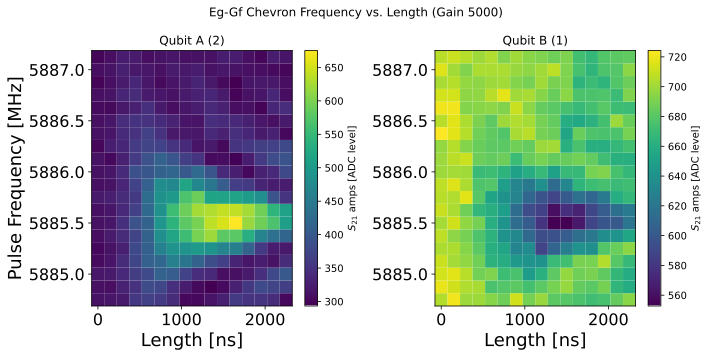

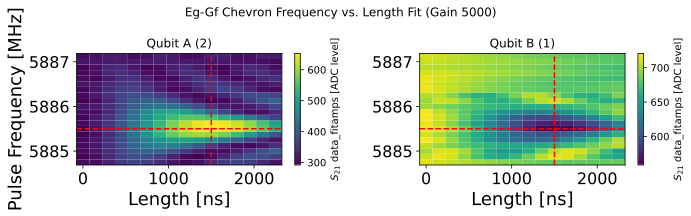

opt freq 5885.5 opt len 1.5
gain 5862.068965517241 stop_len 2.1879310344827587 approx freq 5885.827586206897


  0%|          | 0/20 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241007\00031_rabi_EgGf_freqlen_chevron_qubit21.h5
Attempted to init fitparam 1 to 2.999408983451536, which is out of bounds 0.09141055949566589 to 2.2852639873916467. Instead init to 1.1883372734436564
Attempted to init fitparam 1 to 2.5709219858156023, which is out of bounds 0.09141055949566589 to 2.2852639873916467. Instead init to 1.1883372734436564


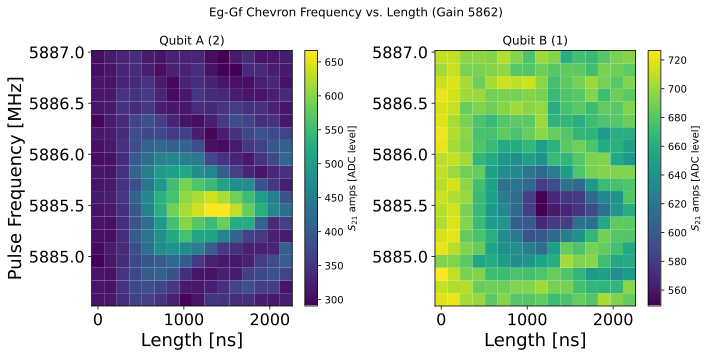

opt freq 5885.452586206897 opt len 1.3127586206896553
gain 6724.137931034483 stop_len 2.1258620689655174 approx freq 5885.6551724137935


  0%|          | 0/20 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241007\00032_rabi_EgGf_freqlen_chevron_qubit21.h5
Attempted to init fitparam 1 to 3.086982968369829, which is out of bounds 0.09407948094079481 to 2.35198702351987. Instead init to 1.2230332522303324
Attempted to init fitparam 1 to 2.6459854014598534, which is out of bounds 0.09407948094079481 to 2.35198702351987. Instead init to 1.2230332522303324
Attempted to init fitparam 1 to 3.527980535279805, which is out of bounds 0.09407948094079481 to 2.35198702351987. Instead init to 1.2230332522303324


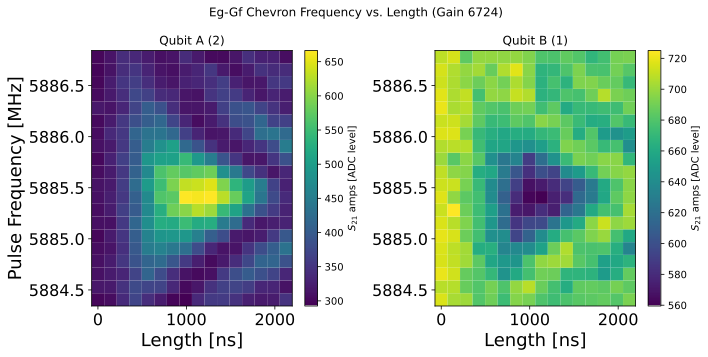

opt freq 5885.4051724137935 opt len 1.133793103448276
gain 7586.206896551725 stop_len 2.0637931034482757 approx freq 5885.482758620689


  0%|          | 0/20 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241007\00033_rabi_EgGf_freqlen_chevron_qubit21.h5
Attempted to init fitparam 1 to 3.634085213032582, which is out of bounds 0.09690893901420218 to 2.4227234753550544. Instead init to 1.2598162071846284


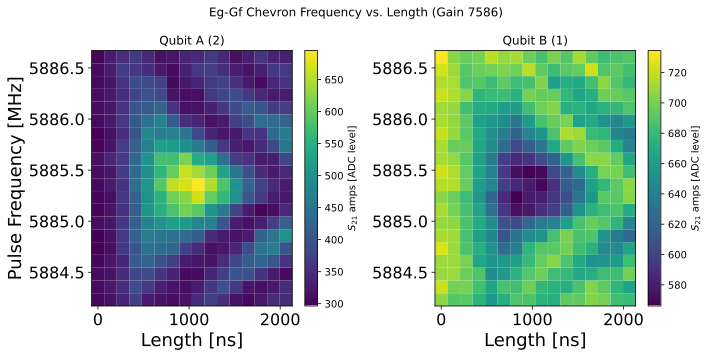

opt freq 5885.357758620689 opt len 0.963103448275862
gain 8448.275862068966 stop_len 2.001724137931035 approx freq 5885.310344827586


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [61]:
for gain, stop_len, approx_freq in zip(gain_sweep, len_approx_gains, freq_approx_gains):
    # if gain < 27900: continue
    print('gain', gain, 'stop_len', stop_len, 'approx freq', approx_freq)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 2.5 # MHz
    npts_f = 20
    # npts_f = 60

    start_len = 0
    span_len = stop_len - start_len
    npts_len = 15
    
    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=approx_freq - 0.5*span_f, # start freq [MHz],
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=start_len, # pulse length (sigma) [us]
        step_len=span_len/npts_len, # [us]
        expts_len=npts_len+1,
        gain=int(gain),
        reps=800,
        # reps=2000,
        # reps=10,
        pulse_type='flat_top',
        measure_f=None,
        post_process=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
    )

    success = False
    while not success:
        try:
            rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(rabiEgGfFreqLenChevron.save_data())
    data = rabiEgGfFreqLenChevron.analyze(data=None)
    plot_freqs, plot_lens = rabiEgGfFreqLenChevron.display(data=data, fit=True, signs=signs, verbose=False)

    opt_freqs.append(plot_freqs[opt_fit_index])
    opt_lens.append(plot_lens[opt_fit_index])
    print('opt freq', opt_freqs[-1], 'opt len', opt_lens[-1])

In [ ]:
print(saved_files)

In [62]:
print('gain sweep\n', gain_sweep.tolist())
print('optimal lens\n', opt_lens)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

plt.plot(gain_sweep, opt_lens, '.-')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.show()

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


gain sweep
 [5000.0, 5862.068965517241, 6724.137931034483, 7586.206896551725, 8448.275862068966, 9310.344827586207, 10172.41379310345, 11034.48275862069, 11896.551724137931, 12758.620689655172, 13620.689655172413, 14482.758620689656, 15344.827586206897, 16206.896551724138, 17068.96551724138, 17931.034482758623, 18793.103448275862, 19655.1724137931, 20517.241379310344, 21379.310344827587, 22241.379310344826, 23103.44827586207, 23965.51724137931, 24827.58620689655, 25689.655172413793, 26551.724137931036, 27413.793103448275, 28275.862068965518, 29137.93103448276, 30000.0]
optimal lens
 [1.5, 1.3127586206896553, 1.133793103448276, 0.963103448275862]
optimal freqs
 [5885.5, 5885.452586206897, 5885.4051724137935, 5885.357758620689]
saved files
 ['S:\\QRAM\\qram_4QR2\\data\\data_241007\\00030_rabi_EgGf_freqlen_chevron_qubit21.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241007\\00031_rabi_EgGf_freqlen_chevron_qubit21.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241007\\00032_rabi_EgGf_freqlen_chevron_qubit

ValueError: x and y must have same first dimension, but have shapes (30,) and (4,)

Replot data above

In [16]:
signs = [-1, -1, 1, 1] # whether the period occurs at the max (1) or min (-1)
opt_fit_index = 0

In [17]:
# saved_files = [
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00165_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00166_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00167_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00168_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00169_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00170_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00171_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00172_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00173_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00174_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00175_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00176_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00186_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00187_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00188_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00189_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00190_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00191_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00192_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00193_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00194_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00195_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00196_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00197_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00198_rabi_EgGf_freqlen_chevron_qubit21.h5',
# ]

gain_sweep = [0]*len(saved_files)
opt_freqs = [0]*len(saved_files)
opt_lens = [0]*len(saved_files)

In [ ]:
# going through files again to get opt lens, freqs
for i_file, saved_file in enumerate(saved_files):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    rabiEgGfLenChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, file_name)
    rabiEgGfLenChevron.cfg.expt = AttrDict(attrs['config']['expt'])
    # print(temp_data.keys())

    # if file_name != '00013_rabi_EgGf_freqlen_chevron_qubit21.h5': continue
    fitparams=[None, 1/temp_data['lenpts'][-1], None, None]

    data = rabiEgGfFreqLenChevron.analyze(data=temp_data, fitparams=fitparams)
    plot_freqs, plot_lens = rabiEgGfFreqLenChevron.display(data=data, fit=True, signs=signs)

    print('gain', rabiEgGfLenChevron.cfg.expt.gain)
    print('plot freq', plot_freqs[opt_fit_index])
    print('plot len', plot_lens[opt_fit_index])
    gain_sweep[i_file] = rabiEgGfLenChevron.cfg.expt.gain
    opt_freqs[i_file] = plot_freqs[opt_fit_index]
    opt_lens[i_file] = plot_lens[opt_fit_index]

In [ ]:
print('gain sweep\n', gain_sweep)
print('optimal lens\n', opt_lens)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

print(len(gain_sweep))
print(len(opt_lens))
print(len(opt_freqs))

plt.plot(gain_sweep, opt_lens, '.-')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.show()

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


### Alternative: fine gain vs freq sweep setup

In [ ]:
npts = 15

gain_sweep = np.linspace(14000, 18500, npts) # Q3/Q1
# gain_sweep = np.linspace(5000, 30000, npts) # Q2/Q1
print('gain_sweep\n', gain_sweep)

len_approx_gains = 1.5*np.linspace(0.350, 0.250, npts) # Q3/Q1
# len_approx_gains = 1.5*np.linspace(1.00, 0.300, npts) # Q2/Q1
print('max len for each gain (us)\n', len_approx_gains)

freq_approx_gains = np.linspace(5148.0, 5145.0, npts) # approx freq for each gain # Q3/Q1
# freq_approx_gains = np.linspace(5887.0, 5883, npts) # approx freq for each gain # Q2/Q1

print('approx freq for each gain\n', freq_approx_gains)
print('qubits', qubits)

opt_lens = len_approx_gains/1.5
opt_freqs = []
saved_files = []
save_files = True

In [ ]:
for gain, stop_len, approx_freq in zip(gain_sweep, len_approx_gains, freq_approx_gains):
    # if gain < 27900: continue
    print('gain', int(gain), 'stop_len', stop_len, 'approx freq', approx_freq)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 2.5 # MHz
    # npts_f = 30
    npts_f = 60

    start_len = stop_len/1.5
    span_len = 0


    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=approx_freq - 0.5*span_f, # start freq [MHz],
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f+1, # number of different freq experiments, 
        start_len=start_len, # pulse length (sigma) [us]
        step_len=span_len/npts_len, # [us]
        expts_len=1,
        gain=int(gain),
        reps=1000,
        # reps=2000,
        # reps=10,
        pulse_type='flat_top',
        measure_f=None,
        post_process=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
    )

    success = False
    while not success:
        try:
            rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(rabiEgGfFreqLenChevron.save_data())
    
    plt.figure(figsize=(9, 8))
    data = rabiEgGfFreqLenChevron.data
    plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
    # plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
    len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
    
    amps_freq_cut_qA = data['amps'][0][:, len_ind]
    amps_freq_cut_qB = data['amps'][1][:, len_ind]
    p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
    p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
    fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
    fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
    freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
    freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
    print('QA freq with max amp', freq_max_amp_qA)
    print('QB freq with min amp', freq_min_amp_qB)
    plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
    plt.subplot(211, title=f'QA ({qubits[0]})')
    plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
    plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
    plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
    plt.ylabel('Amplitude [ADC units]')
    
    plt.subplot(212, title=f'QB ({qubits[1]})')
    plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
    plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
    plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
    # plt.axvline(5890.45, color='r', linestyle='--')
    # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [ADC units]')
    plt.tight_layout()
    plt.show()

    opt_freqs.append((freq_max_amp_qA + freq_max_amp_qB)/2)
    print('opt freq', opt_freqs[-1])

In [ ]:
print(saved_files)

In [ ]:
print('gain sweep\n', gain_sweep.tolist())
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


In [65]:
['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00086_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00087_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00088_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00089_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00090_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00091_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00092_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00093_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00094_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00095_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00096_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00097_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00098_rabi_EgGf_freqlen_chevron_qubit31.h5']
gain_sweep = [0]*len(saved_files)
opt_freqs = [0]*len(saved_files)

In [ ]:
# going through files again to get opt lens, freqs
for i_file, saved_file in enumerate(saved_files):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    rabiEgGfLenChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, file_name)
    rabiEgGfLenChevron.cfg.expt = AttrDict(attrs['config']['expt'])
    # print(temp_data.keys())
    
    plt.figure(figsize=(9, 8))
    data = temp_data
    plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
    # plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
    len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
    
    amps_freq_cut_qA = data['amps'][0][:, len_ind]
    amps_freq_cut_qB = data['amps'][1][:, len_ind]
    p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
    p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
    fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
    fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
    freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
    freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
    print('QA freq with max amp', freq_max_amp_qA)
    print('QB freq with min amp', freq_min_amp_qB)
    plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
    plt.subplot(211, title=f'QA ({qubits[0]})')
    plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
    plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
    plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
    plt.ylabel('Amplitude [ADC units]')
    
    plt.subplot(212, title=f'QB ({qubits[1]})')
    plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
    plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
    plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
    # plt.axvline(5890.45, color='r', linestyle='--')
    # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [ADC units]')
    plt.tight_layout()
    plt.show()

    print('gain', rabiEgGfLenChevron.cfg.expt.gain)
    print('plot freq', plot_freqs[opt_fit_index])
    
    gain_sweep[i_file] = rabiEgGfLenChevron.cfg.expt.gain
    opt_freqs[i_file] = (freq_max_amp_qA + freq_min_amp_qB)/2

In [ ]:
print('gain sweep\n', gain_sweep)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

print(len(gain_sweep))
print(len(opt_freqs))

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


## [Auto3] Run again with length rabi and error amplification on selected frequencies

### Functions for fine calibration experiments

In [12]:
def run_swap_length_rabi(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, save_data=True, saved_files=None):
    print(f"-------- swap length rabi --------")
    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )
    
    lengthrabiEgGf.cfg = AttrDict(deepcopy(yaml_cfg))
    
    stop_len = opt_len*1.5
    start_len = 0
    span_len = stop_len - start_len
    npts_len = 101
    # npts_len = 50

    sweep2Q_q = qubits[0]
    lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq
    print('gain', lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
          'freq', lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])

    lengthrabiEgGf.cfg.expt = dict(
        start=start_len, # pulse length (sigma) [us]
        step=span_len/npts_len, # [us]
        expts=npts_len,
        # reps=60,
        # loops=10,
        reps=1000,
        # loops=3,
        # post_process='threshold',
        post_process=None,
        singleshot_reps=20000,
        measure_f=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

    )

    try:
        lengthrabiEgGf.acquire(progress=True, debug=True)
        success = True
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    if save_data:
        assert saved_files is not None
        saved_files.append(lengthrabiEgGf.save_data())
        print('Saved', saved_files[-1])
    data = lengthrabiEgGf.analyze(data=None, fit=True)
    p, pcov = meas.fitting.get_best_fit(data, prefixes=['fitA', 'fitB'], check_measures=['amps'])
    if p[2] > 180:
        p[2] = p[2] - 360
    elif p[2] < -180:
        p[2] = p[2] + 360
    if p[2] < 0:
        pi_len = (1 / 2 - p[2] / 180) / 2 / p[1]
    else:
        pi_len = (3 / 2 - p[2] / 180) / 2 / p[1]

    lengthrabiEgGf.display(data=data, fit=True)
    # new_opt_len = pi_lens[opt_fit_index]
    new_opt_len = pi_len

    return new_opt_len

In [13]:
def run_swap_piminuspi(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, save_data=True, saved_files=None):
    print(f"-------- swap pi minus pi --------")
    piminuspi = meas.PiMinusPiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"PiMinusPiEgGfExptQ{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))

    piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_len
    piminuspi.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq

    # span_f = 1.5
    span_f = 0.5
    # npts_f = 70
    npts_f = 30

    piminuspi.cfg.expt = dict(
        start_N=0, # number gate repetitions
        # step_N=2,
        step_N=1,
        expts_N=10,
        start_f=opt_freq-span_f/2,
        step_f=span_f/npts_f,
        expts_f=npts_f+1,

        reps=1500,
        loops=1,

        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        # singleshot_reps=5000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
    )

    print(piminuspi.cfg)
    try:
        piminuspi.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    data = piminuspi.data
    piminuspi.analyze(fit=True)
    piminuspi.display(fit=True)

    if save_data:
        assert saved_files is not None
        saved_files.append(piminuspi.save_data())
        print('Saved', saved_files[-1])

    return data['best_freq']

In [14]:
def run_swap_error_amp(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, save_data=True, saved_files=None):
    print(f"-------- swap error amplification --------")
    npulsecalib = meas.NPulseEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))

    npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_len
    npulsecalib.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq

    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=4,
        reps=4000,
        loops=20,

        pulse_type='flat_top',
        # post_process='threshold',
        post_process='scale',
        singleshot_reps=15000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
    )

    print(npulsecalib.cfg)
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    if save_data:
        assert saved_files is not None
        saved_files.append(npulsecalib.save_data())
        print('Saved', saved_files[-1])

    data = npulsecalib.data
    npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)

    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['avgi'])

    if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
    else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
    if use_q == qDrive: sign = 1
    else: sign = -1
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - sign*angle_err)/180
    new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] / amp_ratio

    print('pi len precise', new_opt_len, f'adjustment ratio {amp_ratio} from Q{use_q}')
    return new_opt_len

### Start the fine calibration

In [15]:
do_length_rabi = do_piminuspi = do_error_amp = False

# do_length_rabi = True
# do_piminuspi = True
do_error_amp = True

# put an override=True flag to force skipping certain qubits

save_files = True

In [16]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [17]:
new_opt_lens = []
new_opt_lens2 = []
new_opt_freqs = []

saved_files_lengthrabi = []
saved_files_piminuspi = []
saved_files_error_amp = []

In [18]:
gain_sweep=[5000.0, 5862.068965517241, 6724.137931034483, 7586.206896551725, 8448.275862068966, 9310.344827586207, 10172.41379310345, 11034.48275862069, 11896.551724137931, 12758.620689655172, 13620.689655172413, 14482.758620689656, 15344.827586206897, 16206.896551724138, 17068.96551724138, 17931.034482758623, 18793.103448275862, 19655.1724137931, 20517.241379310344, 21379.310344827587, 22241.379310344826, 23103.44827586207, 23965.51724137931, 24827.58620689655, 25689.655172413793, 26551.724137931036, 27413.793103448275, 28275.862068965518, 29137.93103448276, 30000.0]
opt_lens=[0.9263092295372497, 0.7646448260702138, 0.6657136724811262, 0.6044648975629047, 0.5319622431605235, 0.4812122713230715, 0.4434384953802377, 0.41854120703985725, 0.392750497098164, 0.36619022875153007, 0.3468405948361464, 0.3212725271894173, 0.29432627133758243, 0.2897175619557566, 0.2743933280136453, 0.26365664446108106, 0.2539450608791854, 0.24069439999223785, 0.2327466493591943, 0.2214116697583744, 0.21559549573933254, 0.20795388302792414, 0.20089740738855758, 0.1939107194133164, 0.1873490418514079, 0.18105399398559807, 0.1722477018768357, 0.166402619019359, 0.1556424489344312, 0.1644693458781992]
opt_freqs=[5145.025862068966, 5144.801724137931, 5144.577586206897, 5144.228448275862, 5144.004310344828, 5144.0301724137935, 5143.703238373118, 5143.447371743753, 5143.14291467045, 5142.813414561971, 5142.480219822687, 5142.124025538905, 5141.717729722623, 5141.314786493416, 5140.89185475933, 5140.458904184854, 5139.996910824068, 5139.501121984396, 5139.003126517561, 5138.456439145919, 5137.883153570987, 5137.326711357275, 5136.740341742854, 5136.114362009084, 5135.524566813469, 5134.929490293129, 5134.395167094964, 5133.877521216293, 5132.796928147519]


----------- STARTING GAIN 5000.0 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.996526541673, 4572.845483074933, 0.0, 4209.8719428597715, 4205.61

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.28234274475817 	 angle (deg): -155.125774519394 	 threshold ge: 58.86876957569331
Qubit  (1)
ge fidelity (%): 42.14140471349045 	 angle (deg): -82.15948445108081 	 threshold ge: 473.6803567805561


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00056_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00056_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.9296737655004425
	adjust ratio 0.9963809498686008

From QB: adjust length to 0.8993092733851984
	adjust ratio 1.0300229931471934


best 1 0.0422282056446543
pi len precise 0.8993092733851984 adjustment ratio 1.0300229931471934 from Q1
for gain 5000.0 added swap pi len from error amplification 0.8993092733851984
----------- STARTING GAIN 5862.068965517241 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.61333333333333 	 angle (deg): -154.18121953670502 	 threshold ge: 51.0737086992886
Qubit  (1)
ge fidelity (%): 43.946666666666665 	 angle (deg): -81.86252124383195 	 threshold ge: 472.2361529918826


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00057_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00057_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.7708294611036215
	adjust ratio 0.9919766493816246

From QB: adjust length to 0.7523621833932109
	adjust ratio 1.016325438662543


best 1 0.07495741314940327
pi len precise 0.7523621833932109 adjustment ratio 1.016325438662543 from Q1
for gain 5862.068965517241 added swap pi len from error amplification 0.7523621833932109
----------- STARTING GAIN 6724.137931034483 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 438

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.68666666666667 	 angle (deg): -158.913129831963 	 threshold ge: 67.8766014562043
Qubit  (1)
ge fidelity (%): 43.21333333333333 	 angle (deg): -83.06273181544015 	 threshold ge: 462.1176438502946


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00058_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00058_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.6723873908328935
	adjust ratio 0.9900745932437841

From QB: adjust length to 0.6579395528782058
	adjust ratio 1.0118158568958378


best 1 0.10245959785131169
pi len precise 0.6579395528782058 adjustment ratio 1.0118158568958378 from Q1
for gain 6724.137931034483 added swap pi len from error amplification 0.6579395528782058
----------- STARTING GAIN 7586.206896551725 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 43

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.84 	 angle (deg): -157.84992180855647 	 threshold ge: 44.4547621701862
Qubit  (1)
ge fidelity (%): 44.154805160172 	 angle (deg): -80.61568897646141 	 threshold ge: 458.895730744967


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00059_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00059_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.610189401364494
	adjust ratio 0.9906184804442878

From QB: adjust length to 0.5975428063645506
	adjust ratio 1.0115842599469451


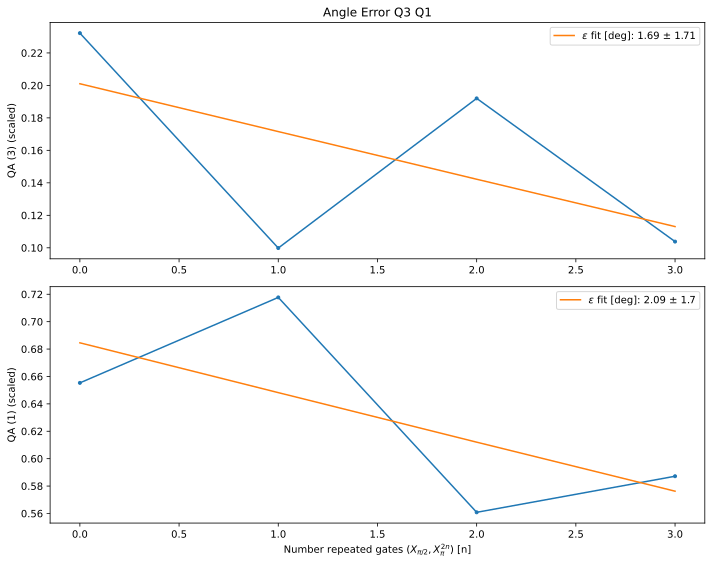

best 1 0.44819198405800037
pi len precise 0.5975428063645506 adjustment ratio 1.0115842599469451 from Q1
for gain 7586.206896551725 added swap pi len from error amplification 0.5975428063645506
----------- STARTING GAIN 8448.275862068966 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 43

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.01333333333334 	 angle (deg): -161.7810207775782 	 threshold ge: 59.299869506006644
Qubit  (1)
ge fidelity (%): 42.96666666666666 	 angle (deg): -82.36695139986709 	 threshold ge: 469.7460927447732


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00060_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00060_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.534764119590083
	adjust ratio 0.9947605377269754

From QB: adjust length to 0.5274826073030018
	adjust ratio 1.0084924806913085


best 1 0.35926328155981807
pi len precise 0.5274826073030018 adjustment ratio 1.0084924806913085 from Q1
for gain 8448.275862068966 added swap pi len from error amplification 0.5274826073030018
----------- STARTING GAIN 9310.344827586207 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 43

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 69.06 	 angle (deg): -161.7294247755502 	 threshold ge: 46.42182211895192
Qubit  (1)
ge fidelity (%): 43.166666666666664 	 angle (deg): -81.73054086808293 	 threshold ge: 479.19950931219887


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00061_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00061_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.48696849888489796
	adjust ratio 0.9881794662796308

From QB: adjust length to 0.4786070726251449
	adjust ratio 1.0054432933546869


best 0 0.39923099253302974
pi len precise 0.48696849888489796 adjustment ratio 0.9881794662796308 from Q3
for gain 9310.344827586207 added swap pi len from error amplification 0.48696849888489796
----------- STARTING GAIN 10172.41379310345 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 67.48891629720991 	 angle (deg): -162.64077601372685 	 threshold ge: 54.416956030319966
Qubit  (1)
ge fidelity (%): 42.72666666666667 	 angle (deg): -81.63822111706456 	 threshold ge: 461.510592886088


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00062_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00062_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.4451006074934571
	adjust ratio 0.9962657608521827

From QB: adjust length to 0.4394396923740471
	adjust ratio 1.0090997765463272


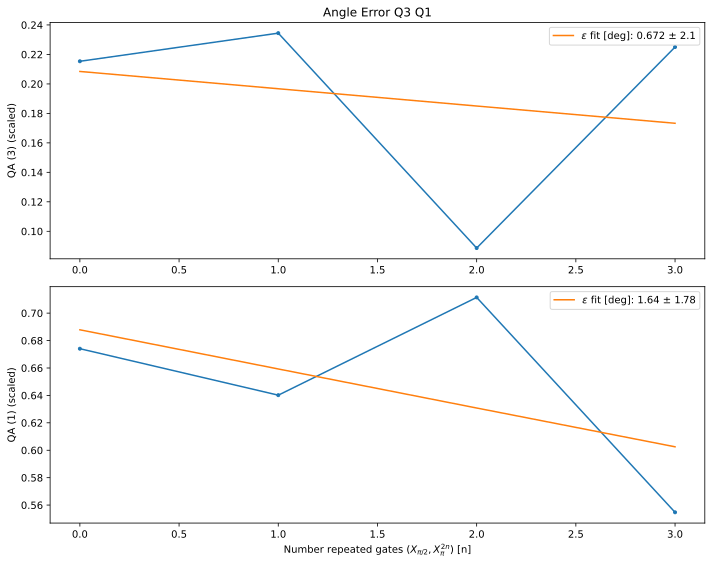

best 1 0.5841901298433966
pi len precise 0.4394396923740471 adjustment ratio 1.0090997765463272 from Q1
for gain 10172.41379310345 added swap pi len from error amplification 0.4394396923740471
----------- STARTING GAIN 11034.48275862069 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 438

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 68.10000000000001 	 angle (deg): -164.26292948286968 	 threshold ge: 43.49898517917677
Qubit  (1)
ge fidelity (%): 41.73472449081636 	 angle (deg): -79.17640970297073 	 threshold ge: 458.83263474980396


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00063_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00063_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.422059356577954
	adjust ratio 0.9916643252109802

From QB: adjust length to 0.41639848669435425
	adjust ratio 1.0051458408567076


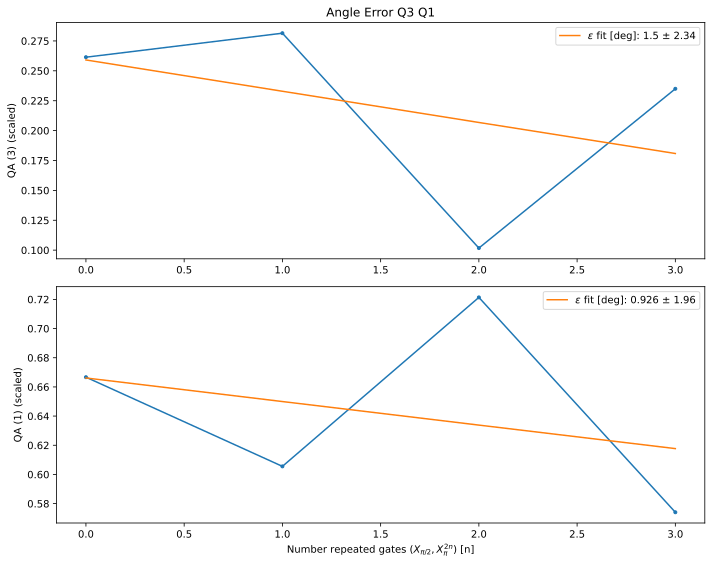

best 0 0.9271927228746739
pi len precise 0.422059356577954 adjustment ratio 0.9916643252109802 from Q3
for gain 11034.48275862069 added swap pi len from error amplification 0.422059356577954
----------- STARTING GAIN 11896.551724137931 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 71.01570052335077 	 angle (deg): -165.9537893771667 	 threshold ge: 42.48737322411813
Qubit  (1)
ge fidelity (%): 42.45333333333333 	 angle (deg): -79.13403137924549 	 threshold ge: 457.09157426321656


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00064_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00064_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.39895234982300143
	adjust ratio 0.9844546529739981

From QB: adjust length to 0.39372327948281777
	adjust ratio 0.997529273895281


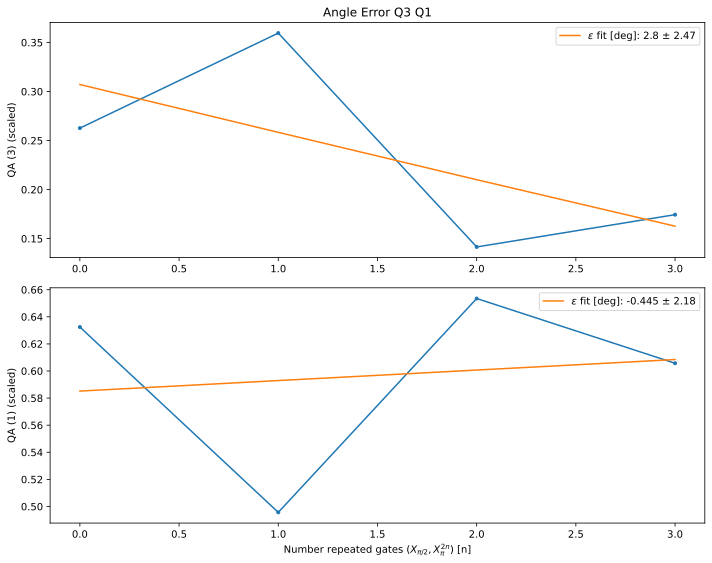

best 0 0.5679911857880722
pi len precise 0.39895234982300143 adjustment ratio 0.9844546529739981 from Q3
for gain 11896.551724137931 added swap pi len from error amplification 0.39895234982300143
----------- STARTING GAIN 12758.620689655172 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 69.06 	 angle (deg): -169.9161394590126 	 threshold ge: 50.41273411952659
Qubit  (1)
ge fidelity (%): 42.486666666666665 	 angle (deg): -81.92498220870733 	 threshold ge: 468.46879496311396


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00065_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00065_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.3733315682100228
	adjust ratio 0.9808713217241911

From QB: adjust length to 0.36852213276778756
	adjust ratio 0.9936722823165498


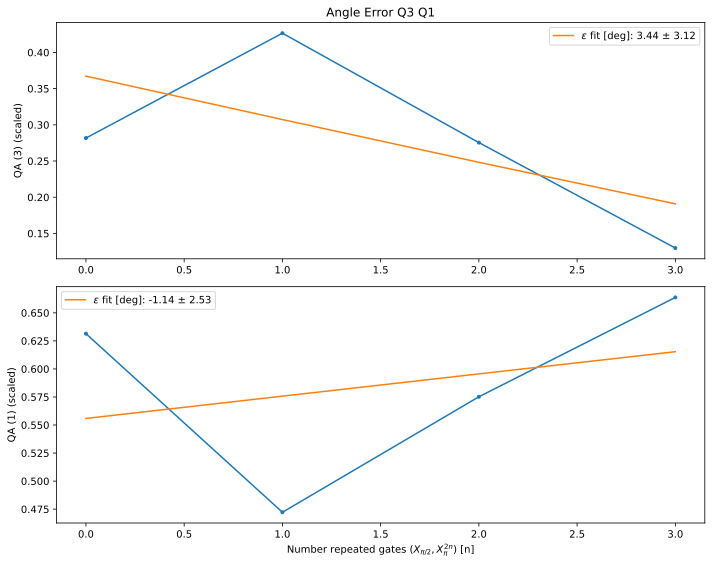

best 0 0.5841398734815941
pi len precise 0.3733315682100228 adjustment ratio 0.9808713217241911 from Q3
for gain 12758.620689655172 added swap pi len from error amplification 0.3733315682100228
----------- STARTING GAIN 13620.689655172413 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 69.62666666666667 	 angle (deg): -170.3902650247252 	 threshold ge: 53.608579337413744
Qubit  (1)
ge fidelity (%): 43.24 	 angle (deg): -81.9160302961533 	 threshold ge: 476.03140542653193


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00066_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00066_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.3521097221528786
	adjust ratio 0.9850355528824493

From QB: adjust length to 0.34777336880204285
	adjust ratio 0.9973178683315816


best 0 0.7402181503133418
pi len precise 0.3521097221528786 adjustment ratio 0.9850355528824493 from Q3
for gain 13620.689655172413 added swap pi len from error amplification 0.3521097221528786
----------- STARTING GAIN 14482.758620689656 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 68.99563318777294 	 angle (deg): -170.90993920548803 	 threshold ge: 48.51087749972447
Qubit  (1)
ge fidelity (%): 42.51475049168306 	 angle (deg): -81.10775196188884 	 threshold ge: 480.6801702687468


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00067_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00067_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.31789487462741756
	adjust ratio 1.0106250614010637

From QB: adjust length to 0.31654382904217243
	adjust ratio 1.014938525769254


best 1 0.3680959002482183
pi len precise 0.31654382904217243 adjustment ratio 1.014938525769254 from Q1
for gain 14482.758620689656 added swap pi len from error amplification 0.31654382904217243
----------- STARTING GAIN 15344.827586206897 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.07333333333334 	 angle (deg): -174.1177956838817 	 threshold ge: 52.020523784999455
Qubit  (1)
ge fidelity (%): 41.59471982399413 	 angle (deg): -79.9541622015246 	 threshold ge: 467.2471735566473


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00068_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00068_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.28995556537417305
	adjust ratio 1.0150737095105218

From QB: adjust length to 0.2878957887434301
	adjust ratio 1.0223361467780383


best 1 0.09435669133974303
pi len precise 0.2878957887434301 adjustment ratio 1.0223361467780383 from Q1
for gain 15344.827586206897 added swap pi len from error amplification 0.2878957887434301
----------- STARTING GAIN 16206.896551724138 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 69.76666666666667 	 angle (deg): -176.02675801287782 	 threshold ge: 68.40702355082044
Qubit  (1)
ge fidelity (%): 43.346666666666664 	 angle (deg): -81.78718368191338 	 threshold ge: 475.08931101602764


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00069_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00069_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.2836619216827754
	adjust ratio 1.0213480901386311

From QB: adjust length to 0.28295652567198243
	adjust ratio 1.0238942581999748


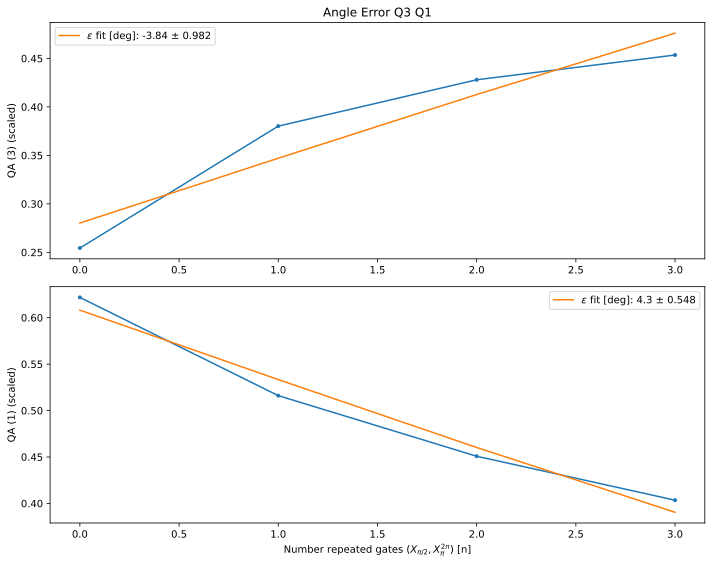

best 1 0.0772284365902212
pi len precise 0.28295652567198243 adjustment ratio 1.0238942581999748 from Q1
for gain 16206.896551724138 added swap pi len from error amplification 0.28295652567198243
----------- STARTING GAIN 17068.96551724138 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 69.69333333333333 	 angle (deg): -177.25973346628973 	 threshold ge: 60.692746937690345
Qubit  (1)
ge fidelity (%): 43.10666666666666 	 angle (deg): -80.93799145688874 	 threshold ge: 476.07539694624404


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00070_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00070_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.2697786382193223
	adjust ratio 1.0171054677448976

From QB: adjust length to 0.268874662378448
	adjust ratio 1.020525049055867


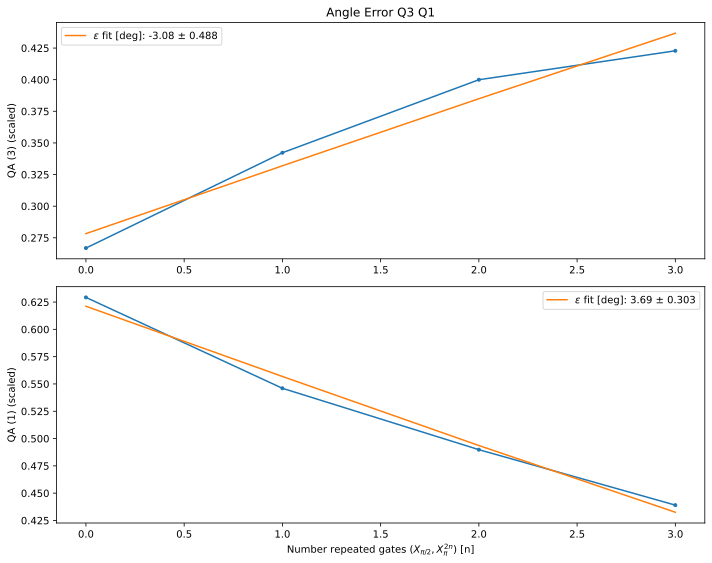

best 1 0.048440957696318995
pi len precise 0.268874662378448 adjustment ratio 1.020525049055867 from Q1
for gain 17068.96551724138 added swap pi len from error amplification 0.268874662378448
----------- STARTING GAIN 17931.034482758623 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 438

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.48234941164705 	 angle (deg): -178.55348823500785 	 threshold ge: 53.46528734447452
Qubit  (1)
ge fidelity (%): 42.18 	 angle (deg): -80.66247197649653 	 threshold ge: 460.30255478106653


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00071_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00071_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.2608054231090685
	adjust ratio 1.010932369879518

From QB: adjust length to 0.2595302063845927
	adjust ratio 1.0158996447233333


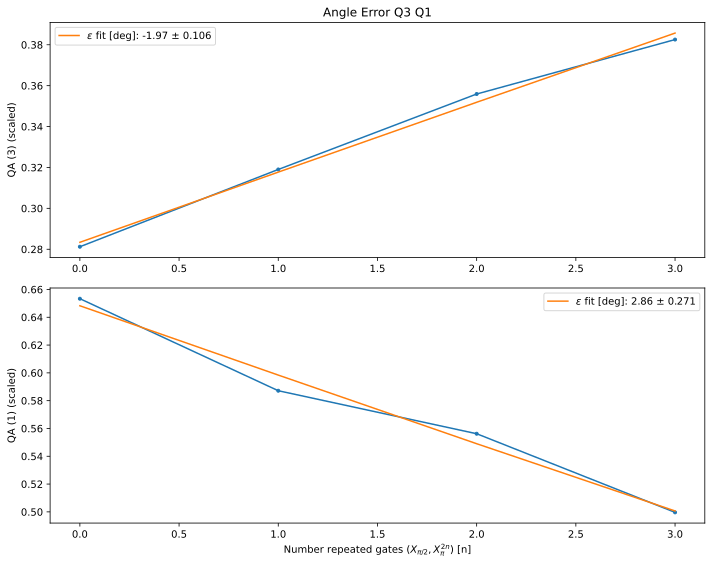

best 0 0.03292425366757444
pi len precise 0.2608054231090685 adjustment ratio 1.010932369879518 from Q3
for gain 17931.034482758623 added swap pi len from error amplification 0.2608054231090685
----------- STARTING GAIN 18793.103448275862 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.71333333333332 	 angle (deg): 174.25213652552537 	 threshold ge: 83.24150373211688
Qubit  (1)
ge fidelity (%): 42.82666666666667 	 angle (deg): -79.92359511678332 	 threshold ge: 456.26385792262766


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00072_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00072_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.2524570836883495
	adjust ratio 1.0058939807475267

From QB: adjust length to 0.2514800054308918
	adjust ratio 1.0098021926000436


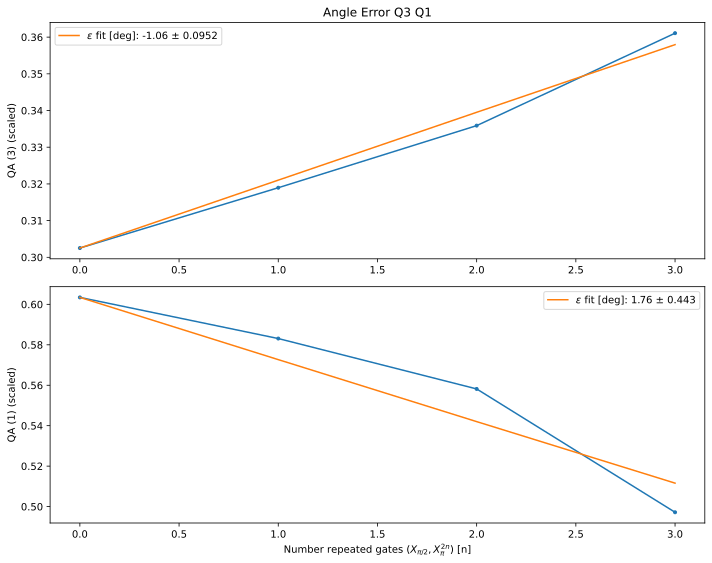

best 0 0.049965152068761565
pi len precise 0.2524570836883495 adjustment ratio 1.0058939807475267 from Q3
for gain 18793.103448275862 added swap pi len from error amplification 0.2524570836883495
----------- STARTING GAIN 19655.1724137931 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.29333333333334 	 angle (deg): 178.6363824396035 	 threshold ge: 57.43913531476852
Qubit  (1)
ge fidelity (%): 42.093333333333334 	 angle (deg): -81.09669138203111 	 threshold ge: 477.20744759193406


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00073_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00073_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.24263741877902947
	adjust ratio 0.9919920892805032

From QB: adjust length to 0.24112249622390652
	adjust ratio 0.9982245695098017


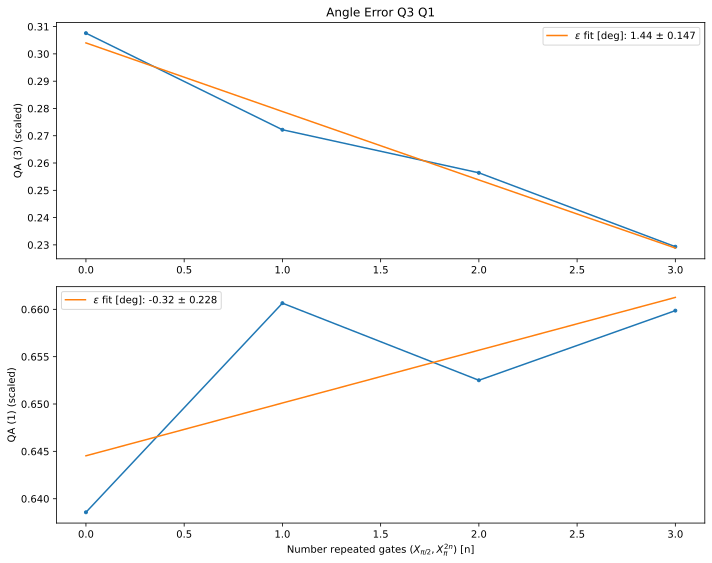

best 0 0.05887268773677701
pi len precise 0.24263741877902947 adjustment ratio 0.9919920892805032 from Q3
for gain 19655.1724137931 added swap pi len from error amplification 0.24263741877902947
----------- STARTING GAIN 20517.241379310344 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.36666666666666 	 angle (deg): 177.3203806604969 	 threshold ge: 59.66195477829149
Qubit  (1)
ge fidelity (%): 42.78809293643121 	 angle (deg): -82.07381517717603 	 threshold ge: 461.0416619617108


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00074_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00074_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.23490552969723175
	adjust ratio 0.9908095805968468

From QB: adjust length to 0.23343447729331532
	adjust ratio 0.9970534432527003


best 0 0.015308872100201234
pi len precise 0.23490552969723175 adjustment ratio 0.9908095805968468 from Q3
for gain 20517.241379310344 added swap pi len from error amplification 0.23490552969723175
----------- STARTING GAIN 21379.310344827587 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.53510391416

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.24666666666667 	 angle (deg): 173.75701190497293 	 threshold ge: 64.3963776294832
Qubit  (1)
ge fidelity (%): 42.693333333333335 	 angle (deg): -84.15449225136668 	 threshold ge: 480.9838656208515


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00075_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00075_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.22585525607961232
	adjust ratio 0.9803255129042842

From QB: adjust length to 0.22413605307476073
	adjust ratio 0.9878449572078544


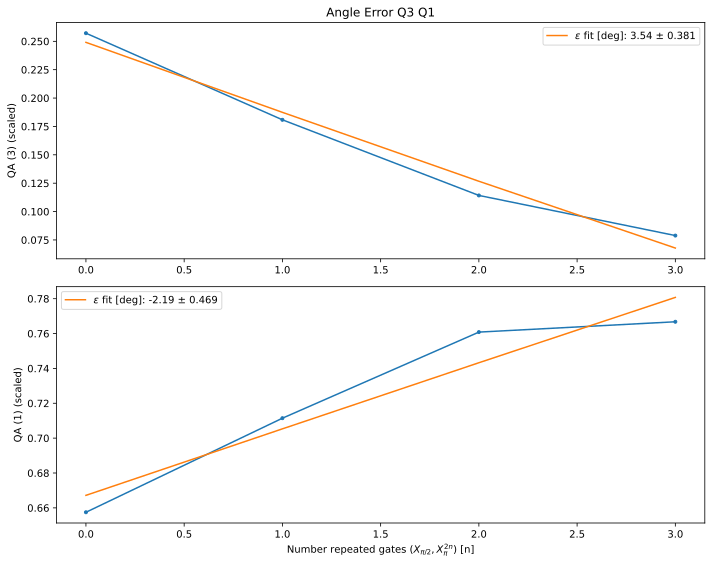

best 0 0.07741117897406796
pi len precise 0.22585525607961232 adjustment ratio 0.9803255129042842 from Q3
for gain 21379.310344827587 added swap pi len from error amplification 0.22585525607961232
----------- STARTING GAIN 22241.379310344826 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 71.50905030167672 	 angle (deg): 170.14453611905904 	 threshold ge: 68.10442148458361
Qubit  (1)
ge fidelity (%): 42.88809626987566 	 angle (deg): -81.66679656593958 	 threshold ge: 466.35195075168184


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00076_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00076_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.21985100406401453
	adjust ratio 0.9806436711863143

From QB: adjust length to 0.21849270493568468
	adjust ratio 0.9867400186326359


best 0 0.08628793087870834
pi len precise 0.21985100406401453 adjustment ratio 0.9806436711863143 from Q3
for gain 22241.379310344826 added swap pi len from error amplification 0.21985100406401453
----------- STARTING GAIN 23103.44827586207 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.38 	 angle (deg): 170.0259091089706 	 threshold ge: 74.54201089205213
Qubit  (1)
ge fidelity (%): 43.39333333333333 	 angle (deg): -83.84628182838938 	 threshold ge: 480.1137711639634


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00077_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00077_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.2128625153518634
	adjust ratio 0.9769398932647899

From QB: adjust length to 0.21085183494263537
	adjust ratio 0.9862559796290146


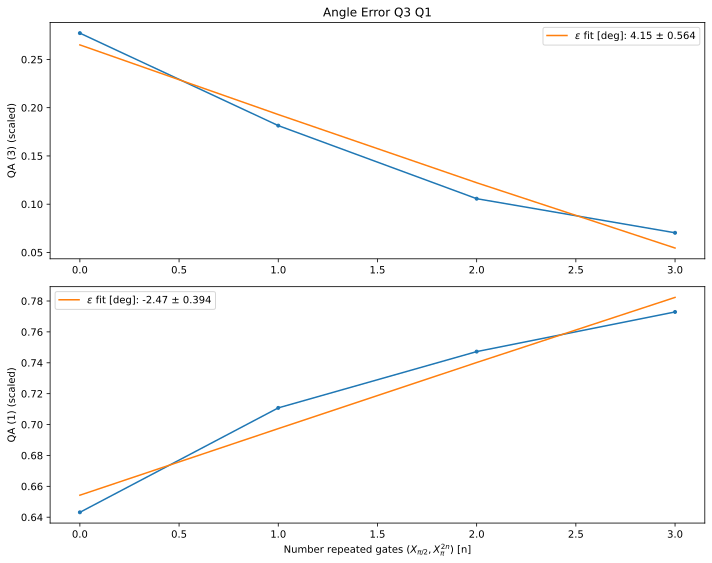

best 1 0.0891062660095909
pi len precise 0.21085183494263537 adjustment ratio 0.9862559796290146 from Q1
for gain 23103.44827586207 added swap pi len from error amplification 0.21085183494263537
----------- STARTING GAIN 23965.51724137931 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 70.14666666666668 	 angle (deg): 168.5130837028215 	 threshold ge: 67.49807318550097
Qubit  (1)
ge fidelity (%): 42.766666666666666 	 angle (deg): -81.72293540592798 	 threshold ge: 460.80507080567213


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00078_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00078_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.20484360550412334
	adjust ratio 0.9807355562510526

From QB: adjust length to 0.20371636375805943
	adjust ratio 0.9861623469146065


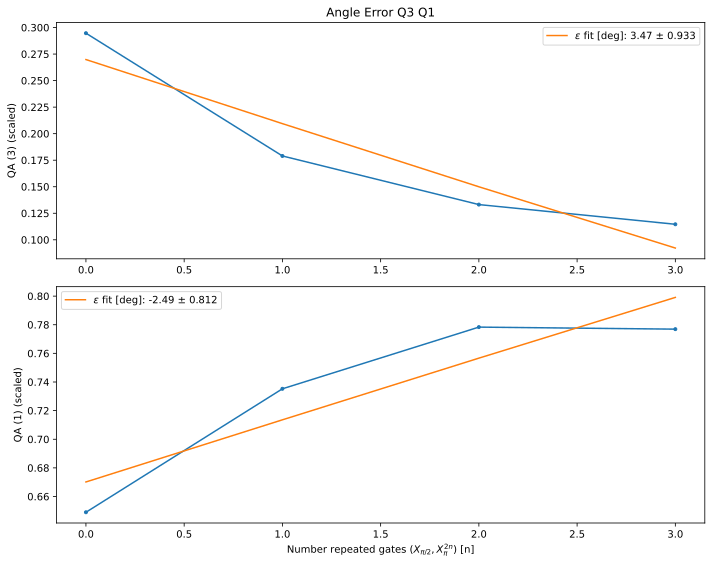

best 1 0.18235008638863454
pi len precise 0.20371636375805943 adjustment ratio 0.9861623469146065 from Q1
for gain 23965.51724137931 added swap pi len from error amplification 0.20371636375805943
----------- STARTING GAIN 24827.58620689655 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 68.56 	 angle (deg): 169.3514107381151 	 threshold ge: 52.796817443864086
Qubit  (1)
ge fidelity (%): 42.42 	 angle (deg): -81.66078014505148 	 threshold ge: 476.20554490477844


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00079_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00079_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.19780608670781796
	adjust ratio 0.9803071414063437

From QB: adjust length to 0.19607115454751897
	adjust ratio 0.98898137189436


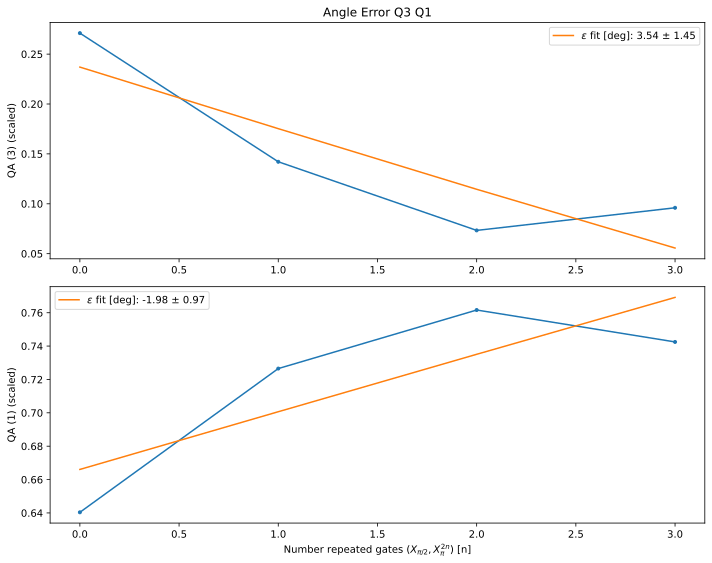

best 1 0.26784520995606464
pi len precise 0.19607115454751897 adjustment ratio 0.98898137189436 from Q1
for gain 24827.58620689655 added swap pi len from error amplification 0.19607115454751897
----------- STARTING GAIN 25689.655172413793 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 72.35333333333334 	 angle (deg): 160.7527656809467 	 threshold ge: 88.61545608069241
Qubit  (1)
ge fidelity (%): 44.11333333333333 	 angle (deg): -81.10658816694585 	 threshold ge: 471.95033747353216


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00080_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00080_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.19117830705598354
	adjust ratio 0.9799701898005913

From QB: adjust length to 0.1895163906491083
	adjust ratio 0.9885637923438861


best 0 0.28545937770858015
pi len precise 0.19117830705598354 adjustment ratio 0.9799701898005913 from Q3
for gain 25689.655172413793 added swap pi len from error amplification 0.19117830705598354
----------- STARTING GAIN 26551.724137931036 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 71.62905430181006 	 angle (deg): 164.5754941693729 	 threshold ge: 66.81231990814848
Qubit  (1)
ge fidelity (%): 43.0147671589053 	 angle (deg): -81.795983512664 	 threshold ge: 469.03834429029257


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00081_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00081_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.18362324854570813
	adjust ratio 0.9860080105299384

From QB: adjust length to 0.18234605397440287
	adjust ratio 0.9929142421201713


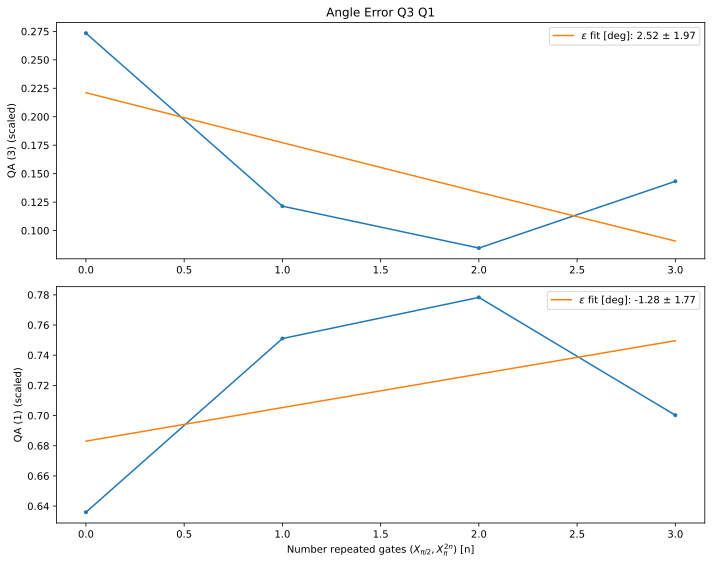

best 0 0.5318921040190014
pi len precise 0.18362324854570813 adjustment ratio 0.9860080105299384 from Q3
for gain 26551.724137931036 added swap pi len from error amplification 0.18362324854570813
----------- STARTING GAIN 27413.793103448275 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 72.16666666666667 	 angle (deg): 163.85292716931903 	 threshold ge: 50.57984754072879
Qubit  (1)
ge fidelity (%): 44.42814760492016 	 angle (deg): -80.23166540582385 	 threshold ge: 456.6753808461294


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00082_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00082_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.17228200764690305
	adjust ratio 0.9998008743307795

From QB: adjust length to 0.17196511481369428
	adjust ratio 1.0016432813332377


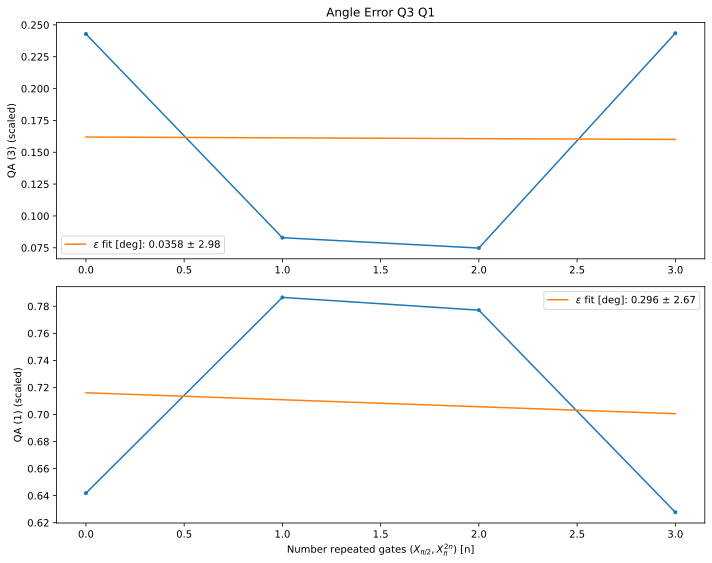

best 1 4.569303204764575
pi len precise 0.17196511481369428 adjustment ratio 1.0016432813332377 from Q1
for gain 27413.793103448275 added swap pi len from error amplification 0.17196511481369428
----------- STARTING GAIN 28275.862068965518 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 71.48666666666666 	 angle (deg): 161.63668380075208 	 threshold ge: 58.07176786901647
Qubit  (1)
ge fidelity (%): 43.6 	 angle (deg): -80.62629993618319 	 threshold ge: 474.4659837932781


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00083_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00083_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.16431336099915259
	adjust ratio 1.0127150829823095

From QB: adjust length to 0.16402333858738585
	adjust ratio 1.014505743222057


best 1 0.7202204137567849
pi len precise 0.16402333858738585 adjustment ratio 1.014505743222057 from Q1
for gain 28275.862068965518 added swap pi len from error amplification 0.16402333858738585
----------- STARTING GAIN 29137.93103448276 -----------
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 72.47333333333333 	 angle (deg): 160.11886336076267 	 threshold ge: 57.64027791822025
Qubit  (1)
ge fidelity (%): 42.79333333333334 	 angle (deg): -81.67651073375944 	 threshold ge: 462.89700716605057


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1370

Saving S:\QRAM\qram_4QR2\data\data_241007\00084_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241007\00084_NPulseExptEgGfQ31.h5
From QA: adjust length to 0.15147723730380436
	adjust ratio 1.0274972775102376

From QB: adjust length to 0.15162097138720793
	adjust ratio 1.0265232276935705


best 1 0.469824637156628
pi len precise 0.15162097138720793 adjustment ratio 1.0265232276935705 from Q1
for gain 29137.93103448276 added swap pi len from error amplification 0.15162097138720793
----------- STARTING GAIN 30000.0 -----------


IndexError: list index out of range

In [19]:
# signs = [1, -1, -1, 1] # whether the period occurs at the max (1) or min (-1)
# opt_fit_index = 1

if not save_files: print('WARNING: NOT SAVING FILES!')
for i_gain, gain in enumerate(gain_sweep):
    # if i_gain < 7: continue 
    # if gain < 29130: continue
    # if i_gain not in [3]: continue

    override = False

    print(f'----------- STARTING GAIN {gain} -----------')
    pi_len = opt_lens[i_gain]
    pi_freq = opt_freqs[i_gain]

    # ----- Length rabi ----- #
    # if gain > 22240 and gain < 22243:
    #     override = True
    #     pi_len = yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
    if do_length_rabi and not override:
        pi_len = run_swap_length_rabi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_lengthrabi)
        yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        if len(new_opt_lens) > i_gain:
            new_opt_lens[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from length rabi', pi_len)
        else:
            new_opt_lens.append(pi_len)
            print(f'for gain {gain} added swap pi len from length rabi', pi_len)
    override = False

    # ----- Pi minus pi----- #
    # if gain > 17067 and gain < 17070:
    #     override = True
    #     pi_freq = yaml_cfg.device.qubit.f_EgGf_Q[qDrive]
    if do_piminuspi and not override:
        pi_freq = run_swap_piminuspi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_piminuspi)
        yaml_cfg.device.qubit.f_EgGf_Q[qDrive] = pi_freq
        if len(new_opt_freqs) > i_gain:
            new_opt_freqs[i_gain] = pi_freq
            print(f'for gain {gain} updated swap pi freq from pi minus pi', pi_freq)
        else:
            new_opt_freqs.append(pi_freq)
            print(f'for gain {gain} added swap pi freq from pi minus pi', pi_freq)
    override = False

    # ----- Error amplification ----- #
    if do_error_amp and not override:
        pi_len = run_swap_error_amp(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_error_amp)
        yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        if len(new_opt_lens2) > i_gain:
            new_opt_lens2[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from error amplification', pi_len)
        else:
            new_opt_lens2.append(pi_len)
            print(f'for gain {gain} added swap pi len from error amplification', pi_len)
    override = False

In [22]:
gain_sweep = gain_sweep[:29]

gain_sweep=[5000.0, 5862.068965517241, 6724.137931034483, 7586.206896551725, 8448.275862068966, 9310.344827586207, 10172.41379310345, 11034.48275862069, 11896.551724137931, 12758.620689655172, 13620.689655172413, 14482.758620689656, 15344.827586206897, 16206.896551724138, 17068.96551724138, 17931.034482758623, 18793.103448275862, 19655.1724137931, 20517.241379310344, 21379.310344827587, 22241.379310344826, 23103.44827586207, 23965.51724137931, 24827.58620689655, 25689.655172413793, 26551.724137931036, 27413.793103448275, 28275.862068965518, 29137.93103448276]
new_opt_lens (fine length rabi)=[]
new_opt_lens2 (error amp)=[0.8993092733851984, 0.7523621833932109, 0.6579395528782058, 0.5975428063645506, 0.5274826073030018, 0.48696849888489796, 0.4394396923740471, 0.422059356577954, 0.39895234982300143, 0.3733315682100228, 0.3521097221528786, 0.31654382904217243, 0.2878957887434301, 0.28295652567198243, 0.268874662378448, 0.2608054231090685, 0.2524570836883495, 0.24263741877902947, 0.2349055

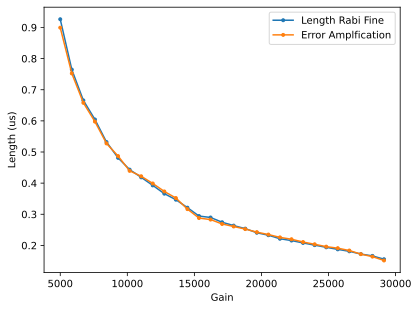

ValueError: x and y must have same first dimension, but have shapes (29,) and (0,)

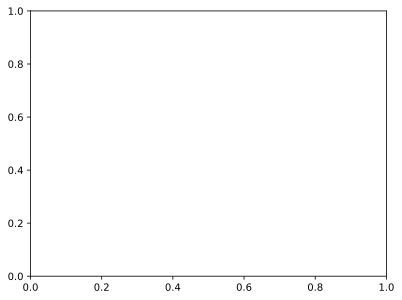

In [25]:
print(f'gain_sweep={np.array(gain_sweep).tolist()}')
print(f'new_opt_lens (fine length rabi)={new_opt_lens}')
print(f'new_opt_lens2 (error amp)={new_opt_lens2}')
print(f'new_opt_freqs={new_opt_freqs}')
print(f'saved_files_lengthrabi={saved_files_lengthrabi}')
print(f'saved_files_piminuspi={saved_files_piminuspi}')
print(f'saved_files_error_amp={saved_files_error_amp}')

# plt.plot(gain_sweep, new_opt_lens, '.-', label='Length Rabi Fine')
plt.plot(gain_sweep, opt_lens[:29], '.-', label='Length Rabi Fine')
plt.plot(gain_sweep, new_opt_lens2, '.-', label='Error Amplfication')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.legend()
plt.show()

plt.plot(gain_sweep, new_opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


Replot data above

In [ ]:
saved_files = []
start_i = 118
stop_i = 130
for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\data\data_240617\\0000{i}_length_rabi_EgGf_qubit31.h5')
    elif i < 100:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\data\data_240617\\000{i}_length_rabi_EgGf_qubit31.h5')
    else:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\data\data_240617\\00{i}_length_rabi_EgGf_qubit31.h5')
print(saved_files)

In [ ]:
# going through files again to get opt lens, freqs
opt_fit_index = 1

plt.figure()
new_opt_lens = []
xmaxes = []
maxes = []
for i_file, saved_file in enumerate(saved_files):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
    # # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
    temp_data, attrs = prev_data(expt_path, file_name)
    cfg = AttrDict(attrs['config'])
    temp_data['xpts'] = cfg.expt.start + cfg.expt.step * np.arange(cfg.expt.expts)
    lengthrabiEgGf.cfg.expt = attrs['config']['expt']
    lengthrabiEgGf.data =temp_data
    gain = lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q]
    # print(lengthrabiEgGf.save_data())
    # print(temp_data.keys())

    data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
    pi_lens = lengthrabiEgGf.display(data=data, fit=True)
    # plt.plot(data['xpts'], data['amps'][0])
    # plt.plot(data['xpts'], np.abs(data['avgq'][0]))
    xmaxes.append(data['xpts'][np.argmax(np.abs(data['amps'][0]))])
    maxes.append(np.max(np.abs(data['amps'][0])))
    print('gain', gain, 'length pi', xmaxes[-1], 'amplitude', maxes[-1])
    # plt.plot(data['xpts'], np.angle(data['avgi'][0] + 1j*data['avgq'][0])*180/np.pi % 180)

    new_opt_lens.append(pi_lens[opt_fit_index])
    print('pi len', new_opt_lens[-1])

plt.figure()
plt.plot(xmaxes, maxes, 'k.-')
print('maxes', maxes)
plt.show()

In [ ]:
print(new_opt_lens)
print(saved_files)

In [ ]:
new_opt_lens[1] = 1.1987019004033739
new_opt_lens[4] = 0.4716335769416996

Sweep ramp times

In [ ]:
gain = 25066
freq = 5885.080333333333
default_len = 0.28170921764829654
default_sigma_ramp_cycles = 3
sigma_n = 4

# len_approx_gains = 1.5*np.linspace(0.470, 0.210, 25)
# # len_approx_gains = 1.5*np.linspace(0.500, 0.300, 21)
# print('max len for each gain (us)\n', len_approx_gains)


# freq_approx_gains = np.linspace(5889.675, 5882.583, 25) # approx freq for each gain
# # freq_approx_gains = np.linspace(5151.5, 5147, 21) # approx freq for each gain

sigma_ramp_cycle_sweep = np.linspace(2, 20, 10)
sigma_ramp_us_sweep = np.array([soc.cycles2us(c, gen_ch=yaml_cfg.hw.soc.dacs.swap_Q.ch[sweep2Q_q]) for c in sigma_ramp_cycle_sweep])
print('sigma_ramp_cycle_sweep', sigma_ramp_cycle_sweep)
print('sigma_ramp in ns', 1e3*sigma_ramp_us_sweep)


default_area = default_len * gain + np.sqrt(2*np.pi)*soc.cycles2us(default_sigma_ramp_cycles, gen_ch=yaml_cfg.hw.soc.dacs.swap_Q.ch[sweep2Q_q])*sp.special.erf(sigma_n/2 / np.sqrt(2))
expected_flat_len = (default_area - np.sqrt(2*np.pi)*sigma_ramp_us_sweep*sp.special.erf(sigma_n/2 / np.sqrt(2))) / gain

print('expected_flat_lens', expected_flat_len)


# print('approx freq for each gain\n', freq_approx_gains)

# opt_lens = []
# opt_freqs = []
# saved_files = []
# save_files = True

# opt_fit_index = 2 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal

In [ ]:
saved_files = []
save_files = True
opt_lens_ramps = []
opt_fit_index = 2

for i_ramp, ramp_cycles in enumerate(sigma_ramp_cycle_sweep):
    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )
    
    stop_len = default_len*1.5

    start_len = 0
    span_len = stop_len - start_len
    npts_len = 151

    sweep2Q_q = qubits[0]
    lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = freq

    lengthrabiEgGf.cfg.expt = dict(
        start=start_len, # pulse length (sigma) [us]
        step=span_len/npts_len, # [us]
        expts=npts_len,
        reps=2000,
        post_process='threshold',
        # post_process=None,
        singleshot_reps=20000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
        sigma_ramp_cycles=ramp_cycles,
    )
    
    # lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
    print(lengthrabiEgGf.cfg)
    # lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
    try:
        lengthrabiEgGf.acquire(progress=True, debug=True)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(lengthrabiEgGf.save_data())
    print('Saved', saved_files[-1])
    data = lengthrabiEgGf.analyze(data=None, fit=True)
    pi_lens = lengthrabiEgGf.display(data=data, fit=True)

    new_opt_lens.append(pi_lens[opt_fit_index])
    print('pi len', new_opt_lens[-1])

## Randomized benchmarking

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    # variations=3,
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=100, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
rbprog.data = temp_data
rbprog.cfg = AttrDict(attrs['config'])
rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
# rbprog.display(fit=True, show_all_vars=False)

In [ ]:
rbprog.save_data()

In [ ]:
# p_irb = 0.9590834452029213 
# p_irb_err = 0.0002387037509980582
# p_rb = 0.9833366468001751 
# p_rb_err = 0.00011879294449350527

p_irb = 0.9378643954169977
p_irb_err = 0.02184963356373672
p_rb = 0.9736931040310971
p_rb_err = 0.01541381511169818 
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
gate_fid, gate_fid_err = meas.fitting.rb_gate_fidelity(p_rb=p_rb, p_irb=p_irb, d=2, p_rb_err=p_rb_err, p_irb_err=p_irb_err)
print(100*gate_fid, '+/-', 100*gate_fid_err, '% gate fidelity')

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

Q2/Q1


In [ ]:
qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|0>|1>'
setup_ZZ = None
# measure_qubits = [qubits[0], qubits[1], 3]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

## 3D sweep to optimize length, gain, freq

In [ ]:
2027 - np.arange(expts_gain)*(10/8000*step_gain)

In [ ]:
start_gain = 2000
step_gain = 2000
expts_gain = 5
gain_sweep = start_gain + step_gain * np.arange(expts_gain)
print(gain_sweep)

sweep2d_expt_progs = []

for ig, gain in enumerate(gain_sweep):
    print('Now setting gain to', gain)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 6 # MHz
    npts_f = 20

    freq_center_pts = 2412 - np.arange(expts_gain)*(10/6000*step_gain)
    if ig==0: print('Freq sweep will be centered at', freq_center_pts)

    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=freq_center_pts[ig] - span_f/2,
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=soc.cycles2us(10), # pulse length (sigma) [us]
        step_len=soc.cycles2us(12), # [us]
        expts_len=30,
        gain=gain,
        reps=1000,
        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        qubits=qubits,
    )

    # rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
    # rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

    # print(rabiEgGfFreqLenChevron.cfg)

    try:
        rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    rabiEgGfFreqLenChevron.analyze(data=None)
    rabiEgGfFreqLenChevron.display(data=None)
    sweep2d_expt_progs.append(rabiEgGfFreqLenChevron)

# Crosstalk calibrations

In [ ]:
crosstalkEcho = meas.CrosstalkEchoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

crosstalkEcho.cfg.expt = dict(
    start=soc.cycles2us(60), # wait time tau [us]
    step=soc.cycles2us(90), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=soc.cycles2us(15), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    expts=200,
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=1500,
    qTest=1,
    qDrives=[2, 3],
    gain_x=10000,
    gain_y=0,
)
print(crosstalkEcho.cfg.expt.step)

print(crosstalkEcho.cfg)

try:
    crosstalkEcho.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# crosstalkEcho = meas.RamseyExperiment(config_file=config_path)
# crosstalkEcho.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = crosstalkEcho.analyze(data=temp_data, fit=True)
# crosstalkEcho.display(data=data, fit=True)

data = crosstalkEcho.data
fitparams=[None, 5/data['xpts'][-1], None, None, None]
crosstalkEcho.analyze(fit=False, fit_num_sin=1, fitparams=fitparams)
crosstalkEcho.display(fit=False, fit_num_sin=1)

qTest = crosstalkEcho.cfg.expt.qTest

data = crosstalkEcho.data
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data['avgi'])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey Echo on Q{qTest} (Ramsey Freq: {crosstalkEcho.cfg.expt.ramsey_freq})')
plt.show()

In [ ]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

## Chevron for gain sweep vs time sweep

In [ ]:
crosstalkEchoTimeChevron = meas.CrosstalkEchoTimeChevronExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span_i = 40000
npts_i = 150


crosstalkEchoTimeChevron.cfg.expt = dict(
    start_i=-span_i//2,
    step_i=int(span_i/npts_i), # [dac level]
    expts_i=npts_i+1,
    # start_t=soc.cycles2us(60), # wait time tau [us]
    # step_t=soc.cycles2us(30), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # expts_t=250,
    start_t=3.5,
    step_t=0,
    expts_t=1,
    sweep_axis='x',
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=4000,
    qTest=1,
    qDrives=[2, 3],
    post_process='scale',
    singleshot_reps=20000,
    thresholds=[0, 42.250179073420334, 0, 0],
    angles=[0, -27.653262746238827, 0, 0],
    ge_avgs=[array([0., 0., 0., 0.]), [29.582075536759927, 24.37702111255693, 38.68021955107352, 29.11635689655172], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    counts_calib=[[8046, 6063, 3431, 2460], [3095, 2322, 8364, 6219]]
)

print(crosstalkEchoTimeChevron.cfg)

try:
    crosstalkEchoTimeChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240218\\00002_CrosstalkEchoTime.h5', filename=None)
crosstalkEchoTimeChevron.data = temp_data
crosstalkEchoTimeChevron.cfg = AttrDict(attrs['config'])
print(crosstalkEchoTimeChevron.cfg.expt)

crosstalkEchoTimeChevron.analyze(fit=True)
crosstalkEchoTimeChevron.display(fit=True)

data = crosstalkEchoTimeChevron.data
plt.figure()
t_ind = np.argmin(np.abs(data['wait_times']-3))
# e_val = np.min(data['amps'])
# g_val = np.max(data['amps'])
plt.plot(data['gain_i_sweep'], data['amps'][:,t_ind], 'o-')
plt.title(f'Crosstalk Calibration on Q{crosstalkEchoTimeChevron.qTest} with drive on {crosstalkEchoTimeChevron.qDrives}')
plt.xlabel(f'Gains ({crosstalkEchoTimeChevron.cfg.expt.sweep_axis} axis) (DAC units)')
plt.ylabel('Population')
plt.axvline(0)
plt.axvline(12500)
plt.axvline(17750)
plt.axvline(-12500)
plt.axvline(-17750)
plt.show()

In [ ]:
crosstalkEchoTimeChevron.save_data()

## Chevron for fixed time

In [ ]:
crosstalkEchoChevron = meas.CrosstalkEchoChevronExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span_x = 40000
npts_x = 60

span_y = 40000
npts_y = 60

crosstalkEchoChevron.cfg.expt = dict(
    start_x=-span_x//2,
    step_x=int(span_x/npts_x), # [dac level]
    expts_x=npts_x,
    start_y=-span_y//2,
    step_y=int(span_y/npts_y), # [dac level]
    expts_y=npts_y,
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=2000,
    qTest=1,
    qDrives=[2, 3],
    wait_us=4,
    post_process='scale',
)

print(crosstalkEchoChevron.cfg)

try:
    crosstalkEchoChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
data = crosstalkEchoChevron.data
for k, a in data.items():
    data[k]=np.array(a)
    if np.shape(data[k]) == (100,):
        data[k] = np.reshape(data[k], (10, 10))
crosstalkEchoChevron.analyze(fit=True)
crosstalkEchoChevron.display(fit=True)